## **지하철역 내부 상가 최적 입지 분석**

### **1.데이터 전처리**

In [2]:
import sklearn
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pip install seaborn
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

In [4]:
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)

pandas: 2.2.3
numpy: 1.23.5
seaborn: 0.13.2
scikit-learn: 1.6.1
matplotlib: 3.10.3


In [ ]:
def preprocess_data(dataframe):

    #필요 없는 열 삭제
    df_retail = dataframe.drop(['연번','호선','상가유형','사업진행단계','계약시작일자','계약종료일자'], axis=1)

    #역명에서 () 제거
    df_retail['역명'] = df_retail['역명'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

    #영업업종이 NaN인거는 일괄적으로 '공실'처리
    df_retail['영업업종'] = df_retail['영업업종'].fillna('공실')
    #영업업종이 공실인 경우 월임대료랑 면적(제곱미터)의 값을 0으로 채웁니다.
    if (df_retail['영업업종']=='공실').any():
        df_retail['월임대료'] = df_retail['월임대료'].fillna(0)
        df_retail['면적(제곱미터)'] = df_retail['면적(제곱미터)'].fillna(0)

    df_retail = df_retail[((df_retail['월임대료'].notna())) & ((df_retail['면적(제곱미터)'].notna()))]
    #나머지 중에서 NaN으로 저장되어 있는 월임대료와 면적 제거.
    #임대진행 표시인것도 일단 공식적으로 그 자리가 비어있다고 판단하겠습니다.
    #영업업종 기타인것도 그냥 내비둘게요.
    
    
    df_retail['월임대료'] = df_retail['월임대료'].astype(float) # 쉼표 제거 후 float형으로 변환

    df_retail['면적(제곱미터)'] = df_retail['면적(제곱미터)'].astype(float) # 쉼표 제거 후 float형으로 변환

    #영업업종을 column으로 변환하고 그에 해당하는 값을 총임대밀도,  
    #역명, 영업업종 기준으로 통계 요약: 평균 면적당 임대료, 점포수, 평균 면적
    df_retail_grouped = df_retail.groupby(['역명', '영업업종']).agg({
        '월임대료': 'mean',
        '상가번호': 'count',
        '면적(제곱미터)': 'mean'
    }).reset_index()
    df_retail_grouped.columns = ['역명', '영업업종', '월임대료', '점포수', '평균 면적'] # 열 이름 변경


    return df_retail_grouped



df1=pd.read_csv('서울교통공사_지하상가 임대정보_20240131.csv', encoding='cp949')
preprocessed_Rental_2401 = preprocess_data(df1)
preprocessed_Rental_2401.to_csv('proprecessed_2401.csv', index=False, encoding='utf-8-sig')

df2=pd.read_csv('서울교통공사_지하상가 임대정보_20240229.csv', encoding='cp949')
preprocessed_Rental_2402 = preprocess_data(df2)
preprocessed_Rental_2402.to_csv('proprecessed_2402.csv', index=False, encoding='utf-8-sig')

df3=pd.read_csv('서울교통공사_지하상가 임대정보_20240331.csv', encoding='cp949')
preprocessed_Rental_2403 = preprocess_data(df3)
preprocessed_Rental_2403.to_csv('proprecessed_2403.csv', index=False, encoding='utf-8-sig')

df4=pd.read_csv('서울교통공사_지하상가 임대정보_20240430.csv', encoding='cp949')
preprocessed_Rental_2404 = preprocess_data(df4)
preprocessed_Rental_2404.to_csv('proprecessed_2404.csv', index=False, encoding='utf-8-sig')

df5=pd.read_csv('서울교통공사_지하상가 임대정보_20240531.csv', encoding='cp949')
preprocessed_Rental_2405 = preprocess_data(df5)
preprocessed_Rental_2405.to_csv('proprecessed_2405.csv', index=False, encoding='utf-8-sig')

df6=pd.read_csv('서울교통공사_지하상가 임대정보_20240630.csv', encoding='cp949')
preprocessed_Rental_2406 = preprocess_data(df6)
preprocessed_Rental_2406.to_csv('proprecessed_2406.csv', index=False, encoding='utf-8-sig')

df7=pd.read_csv('서울교통공사_지하상가 임대정보_20240731.csv', encoding='cp949')
preprocessed_Rental_2407 = preprocess_data(df7)
preprocessed_Rental_2407.to_csv('proprecessed_2407.csv', index=False, encoding='utf-8-sig')

df8=pd.read_csv('서울교통공사_지하상가 임대정보_20240831.csv', encoding='cp949')
preprocessed_Rental_2408 = preprocess_data(df8)
preprocessed_Rental_2408.to_csv('proprecessed_2408.csv', index=False, encoding='utf-8-sig')

df9=pd.read_csv('서울교통공사_지하상가 임대정보_20240930.csv', encoding='cp949')
preprocessed_Rental_2409 = preprocess_data(df9)
preprocessed_Rental_2409.to_csv('proprecessed_2409.csv', index=False, encoding='utf-8-sig')

df12=pd.read_csv('서울교통공사_지하상가 임대정보_20241231.csv', encoding='cp949')
preprocessed_Rental_2412 = preprocess_data(df12)
preprocessed_Rental_2412.to_csv('proprecessed_2412.csv', index=False, encoding='utf-8-sig')



#### **유동인구 데이터 전처리**


- 승 하차의 유동인구가 유의미하게 다른 특성을 가지고 있을 것이라 예상해 통합시키지 않았습니다
- 연령층을 미성년(어린이 포함), 성인, 노인, 외국인으로 나눴습니다.
- 아침 / 낮 / 저녁으로 시간대를 나눴습니다.

- 피벗 테이블을 이용해서 미성년_아침_유동인구,미성년_점심_유동인구,미성년_저녁_유동인구, ... 식으로 열의 이름들을 만들었습니다.

In [ ]:
# 데이터 로드 
df = pd.read_csv('서울교통공사_일별통행통계_20241231.csv', encoding='cp949')

df['월'] = df['수송일자'].str[5:7].astype(int)

# 제거할 컬럼 정의 및 삭제
to_drop = ['연번', '호선', '권종', '04시', '01시', '02시', '03시']
existing_drop = [col for col in to_drop if col in df.columns]
df.drop(columns=existing_drop, inplace=True)

# 역명에서 괄호 제거 
if '역명' in df.columns:
    df['역명'] = df['역명'].apply(lambda x: x.split('(')[0] if '(' in x else x)

# 월별 처리
for month in df['월'].unique():
    month_df = df[df['월'] == month]
    
    hour_cols = []
    for col in df.columns:
        if col[-1] == '시':
            hour_cols.append(col)
    
    # 그룹화할 컬럼 설정 
    if '승객유형' in month_df.columns:
        group_cols = ['역명', '승하차구분', '승객유형']
    else:
        group_cols = ['역명', '승하차구분']
    
    # 각 시간대별 합계를 유지하면서 그룹화
    grouped_df = month_df.groupby(group_cols, as_index=False)[hour_cols].sum()
    
    # 전체 시간대 합계 추가
    grouped_df['합계'] = grouped_df[hour_cols].sum(axis=1)
    
    # 승하차구분으로 정렬 (승차가 먼저 오도록)
    grouped_df['._order'] = grouped_df['승하차구분'].map({'승차':0, '하차':1})
    grouped_df.sort_values(['역명', '._order'], inplace=True)
    grouped_df.drop(columns='._order', inplace=True)
    
    # 결과 저장
    grouped_df.to_csv(f'population_24{month:02}.csv', index=False, encoding='utf-8-sig')
    print(f'{month}월 데이터 요약 저장 완료')

# 수송일자 열 제거
df.drop(columns=['수송일자'], inplace=True)


1월 데이터 요약 저장 완료
2월 데이터 요약 저장 완료
3월 데이터 요약 저장 완료
4월 데이터 요약 저장 완료
5월 데이터 요약 저장 완료
6월 데이터 요약 저장 완료
7월 데이터 요약 저장 완료
8월 데이터 요약 저장 완료
9월 데이터 요약 저장 완료
10월 데이터 요약 저장 완료
11월 데이터 요약 저장 완료
12월 데이터 요약 저장 완료


In [5]:

    #시간대를 기준으로 유동인구 집계
 
    #연령층을 미성년, 성인, 노인, 외국인으로 간소화.

    #미성년은 '중고생','청소년','어린이'를 다 합함.

    #성인은 '일반'임.

    #노인은 '우대권'으로, 외국인은 '외국인' 열로 통합함.

def preprocessing_population(df):
   
        df['승객유형'] = df['승객유형'].replace({
            '어린이':'미성년',
            '청소년':'미성년',
            '중고생':'미성년',
            '일반':'성인',
            '우대권':'노인',
            '외국인':'외국인'  
        })
        df['역명'] = df['역명'].astype(str).str.strip()
        df['역명'] = df['역명'].apply(lambda x: x if x.endswith('역') else x + '역')
        df["아침"] = df[['05시','06시','07시','08시','09시','10시']].sum(axis=1)
        df['점심'] = df[['11시','12시','13시','14시','15시','16시','17시']].sum(axis=1)
        df['저녁'] = df[['18시','19시','20시','21시','22시','23시','00시']].sum(axis=1)

        result = pd.DataFrame()

        list_age = ['미성년','성인','노인','외국인']
        list_time = [ '아침' , '점심', '저녁']

        for age in list_age:
            for time in list_time:
                filtered = df[df['승객유형']==age]
                grouped = filtered.groupby(['역명','승하차구분'])[time].sum()
                result[f'{age}_{time}_유동인구'] = grouped
        
        result['총유동인구'] = result.sum(axis=1)
        result = result.reset_index()
        return result



In [8]:
for i in range (1,10):
    popul = pd.read_csv(f"population_24{i:02}.csv")
    preprocess_pop = preprocessing_population(popul)
    preprocess_pop.to_csv(f"Preprocessed_pop_240{i}.csv", index=False, encoding='utf-8-sig')

popul = pd.read_csv(f"population_2412.csv")
preprocess_pop = preprocessing_population(popul)
preprocess_pop.to_csv("Preprocessed_pop_2412.csv", index=False, encoding='utf-8-sig')

#### **유동인구 하나의 데이터로 합치기**

In [9]:
monthly_df = []

for month in range(1, 10):
    file_path = f"Preprocessed_pop_240{month}.csv"
    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')  
        df['month'] = month
        monthly_df.append(df)
    except:
        FileExistsError




try:
    df_dec = pd.read_csv("Preprocessed_pop_2412.csv", encoding='utf-8-sig')
    df_dec['month'] = 12
    monthly_df.append(df_dec)
except:
    FileExistsError


population_merged_df = pd.concat(monthly_df, ignore_index=True)


cols = ['month'] + [col for col in population_merged_df.columns if col != 'month']
population_merged_df = population_merged_df[cols]


population_merged_df.to_csv("population_month_sum.csv", index=False, encoding='utf-8-sig')

#### **임대정보 하나의 파일로 합치기**

In [ ]:
monthly_dfs = []

for month in range(1, 10):
    file_path = f"proprecessed_240{month}.csv"
    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')  
        df['month'] = month
        monthly_dfs.append(df)
    except:
        FileExistsError

try:
    df_12 = pd.read_csv("proprecessed__2412.csv", encoding='utf-8-sig')
    df_12['month'] = 12
    monthly_dfs.append(df_12)
except:
    FileExistsError


rental_merged_df = pd.concat(monthly_dfs, ignore_index=True)

cols = ['month'] + [col for col in rental_merged_df.columns if col != 'month']
rental_merged_df= rental_merged_df[cols]

rental_merged_df.to_csv("Rental_month_sum.csv", index=False, encoding='utf-8-sig')

In [ ]:
#공실 수를 따로 테이블로 빼줬습니다
empty_store = rental_merged_df[rental_merged_df['영업업종'] == '공실']
empty_store = empty_store.groupby(['역명', 'month']).agg({
    '점포수': 'sum'
})
empty_store = empty_store.reset_index()
empty_store.columns = ['역명', 'month', '공실수']

In [12]:
empty_store.head()

,역명,month,공실수
0,가락시장역,1,1
1,가락시장역,2,1
2,가락시장역,3,1
3,강남구청역,1,1
4,강남구청역,2,2


- 밑의 코드와 결과적으로 하는 일은 동일하나, 여기선 점포수_업종이름 열들을 만들 겁니다.

In [13]:
new_df = rental_merged_df
new_df = new_df.groupby(['month','역명','영업업종'])['점포수'].sum().reset_index()

new_df = new_df.pivot(index = ['month','역명'], columns = '영업업종' , values = '점포수').fillna(0)
#공실 열 제거
new_df = new_df.drop(columns=['공실'])

#열 이름 앞에 '점포수'추가
new_df.columns = ['점포수_' + col if col != 'month' and col != '역명' else col for col in new_df.columns]
new_df.reset_index(inplace=True)

- 월별로 되어있는 자료를 병합한 다음, 피벗 변환을 이용해 열을 만들었습니다.

In [14]:
rental_merged_df.head()

,month,역명,영업업종,월임대료,점포수,평균 면적
0,1,가락시장역,공실,0.0,1,30.440
1,1,가락시장역,기타,1012000.0,1,19.840
2,1,가락시장역,식음료,1693000.0,2,22.805
3,1,가락시장역,패션잡화,4099800.0,1,52.160
4,1,가락시장역,편의점,5233461.0,1,33.000


In [ ]:


#평균면적당 임대료 계산
rental_merged_df['평균면적당 임대료'] = rental_merged_df['월임대료']/rental_merged_df['평균 면적']

rental_merged_df = rental_merged_df.groupby(['month','역명','영업업종'])['평균면적당 임대료'].sum().reset_index()

rental_merged_df = rental_merged_df.pivot(index = ['month','역명'], columns = '영업업종' , values = '평균면적당 임대료').fillna(0)
#공실 열 제거
rental_merged_df = rental_merged_df.drop(columns=['공실'])

#열 이름 앞에 '평균면적당 임대료'추가
rental_merged_df.columns = ['평균면적당 임대료_' + col if col != 'month' and col != '역명' else col for col in rental_merged_df.columns]
rental_merged_df.reset_index(inplace=True)
#공실 수,  컬럼을 합치기
rental_merged_df = pd.merge(rental_merged_df, empty_store, on=['역명', 'month'], how='inner')
rental_merged_df = pd.merge(rental_merged_df, new_df, on=['역명','month'],how='inner')
rental_merged_df.tail()

,month,역명,평균면적당 임대료_공유오피스,평균면적당 임대료_기타,평균면적당 임대료_무인프린트,평균면적당 임대료_밀키트,평균면적당 임대료_사무실,평균면적당 임대료_식음료,평균면적당 임대료_의약업,평균면적당 임대료_패션잡화,...,점포수_무인프린트,점포수_밀키트,점포수_사무실,점포수_식음료,점포수_의약업,점포수_패션잡화,점포수_편의점,점포수_플라워,점포수_화상면접,점포수_화장품
797,9,합정역,0.0,67455.007530,132978.723404,0.0,0.0,349454.049693,96034.23106,182354.362005,...,1.0,0.0,0.0,6.0,4.0,9.0,2.0,3.0,0.0,2.0
798,9,행당역,0.0,40800.907912,0.000000,0.0,0.0,0.000000,0.00000,47028.644720,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
799,9,홍제역,0.0,34393.042191,0.000000,0.0,0.0,155953.608247,0.00000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
800,9,회현역,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,184538.235294,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
801,9,효창공원앞역,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,48484.848485,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


#### **데이터 병합**
- 임대정보 월별통합 데이터셋과 총유동인구를 포함한 데이터셋을 합쳤습니다.

In [16]:
rental_merged_df.to_csv("Rental_sumby_month.csv", index=False, encoding='utf-8-sig')

In [ ]:
filename = "Rental_sumby_month.csv"
print("읽어올 파일:", filename)
df_rent = pd.read_csv(filename)
df_rent['역명'] = df_rent['역명'].str.strip().str.lower()

df_popul = pd.read_csv("Population_month_sum.csv", encoding="utf-8-sig")
df_popul['역명'] = df_popul['역명'].str.strip().str.lower()


#데이터프레임 병합
merged_df = pd.merge(df_popul, df_rent, on='역명', how='inner')
merged_df = merged_df[merged_df['month_x'] == merged_df['month_y']].copy()

merged_df.drop(columns=['month_y'], inplace=True)
merged_df.rename(columns={'month_x': 'month'}, inplace=True)

merged_df.to_csv("merged.csv", index=False, encoding='utf-8-sig')
print(merged_df)

읽어올 파일: Rental_sumby_month.csv
       month      역명 승하차구분  미성년_아침_유동인구  미성년_점심_유동인구  미성년_저녁_유동인구  성인_아침_유동인구  \
0          1   가락시장역    승차         2081         5058         1850      100710   
3          1   가락시장역    하차         1355         4177         4293      125572   
6          1   강남구청역    승차          623         3828         3079       29258   
10         1   강남구청역    하차         2110         4286         1533      286790   
26         1   강동구청역    승차         1860         4506         1336      103752   
...      ...     ...   ...          ...          ...          ...         ...   
14399      9     홍제역    하차         1107         6858         5482       52702   
14408      9     회현역    승차          457         3799         1531       33883   
14417      9     회현역    하차         1145         4285          827      302334   
14426      9  효창공원앞역    승차         1058         3018         1326       57335   
14435      9  효창공원앞역    하차         1428         2344         1600       46659 

In [ ]:
#features = ['month', '역명', '승하차구분', '미성년_아침_유동인구', '미성년_점심_유동인구', '미성년_저녁_유동인구',
# '성인_아침_유동인구', '성인_점심_유동인구', '성인_저녁_유동인구',
# '노인_아침_유동인구', '노인_점심_유동인구', '노인_저녁_유동인구',
# '외국인_아침_유동인구', '외국인_점심_유동인구', '외국인_저녁_유동인구', '총유동인구',
# '평균면적당 임대료_공유오피스', '평균면적당 임대료_기타', '평균면적당 임대료_무인프린트', '평균면적당 임대료_밀키트',
# '평균면적당 임대료_사무실', '평균면적당 임대료_식음료', '평균면적당 임대료_의약업', '평균면적당 임대료_패션잡화',
# '평균면적당 임대료_편의점', '평균면적당 임대료_플라워', '평균면적당 임대료_화상면접', '평균면적당 임대료_화장품',
# '공실수', '점포수_공유오피스', '점포수_기타', '점포수_무인프린트', '점포수_밀키트',
# '점포수_사무실', '점포수_식음료', '점포수_의약업', '점포수_패션잡화',
# '점포수_편의점', '점포수_플라워', '점포수_화상면접', '점포수_화장품']

#### 시험할 군집 목록

In [18]:

#유동인구 특성
minor_pop = ['미성년_아침_유동인구','미성년_점심_유동인구','미성년_저녁_유동인구']
adult_pop = ['성인_아침_유동인구','성인_점심_유동인구','성인_저녁_유동인구']
old_pop = ['노인_아침_유동인구','노인_점심_유동인구','노인_저녁_유동인구']
for_pop = ['외국인_아침_유동인구','외국인_점심_유동인구','외국인_저녁_유동인구']
total_pop = ['총유동인구']

#잠재수익 특성
potential = ['평균면적당 임대료_공유오피스', '평균면적당 임대료_무인프린트', '평균면적당 임대료_밀키트',
            '평균면적당 임대료_사무실', '평균면적당 임대료_식음료', '평균면적당 임대료_의약업', '평균면적당 임대료_패션잡화',
            '평균면적당 임대료_편의점', '평균면적당 임대료_플라워', '평균면적당 임대료_화상면접', '평균면적당 임대료_화장품']
#밀도특성
density = ['점포수_공유오피스', '점포수_무인프린트', '점포수_밀키트',
            '점포수_사무실', '점포수_식음료', '점포수_의약업', '점포수_패션잡화',
            '점포수_편의점', '점포수_플라워', '점포수_화상면접', '점포수_화장품']
#입지기회는 그냥 공실수를 지표로 삼겠습니다다


### **2.클러스터링**
- 이전 학습의 결과 군집별 특성이 애매하게 도출되는 것 같았습니다.

- 목표는 상권 특성을 명확히 몇 가지로 분류해서 교집합을 찾아내는 것입니다. 

- 유동인구는 유동인구끼리, 업종은 업종끼리 클러스터링을 진행했습니다.

- 그러면 클러스터링 라벨을 분석하기가 쉽다고 생각했습니다.





#### **클러스터링 진행:K-MEANS, DBSCAN, MEAN-SHIFT**

#### 클러스터링 시각화 함수

In [ ]:
def visualize_clustering(df, method_name):
    
    print(" visualize_clustering 디버깅")
    print("method_name:", method_name)
    print("찾으려는 라벨 컬럼:", f"{method_name}_label")
    print("df 컬럼:", df.columns.tolist())

    label_col = f'{method_name}_label'
    
    # 클러스터 라벨 확인
    if label_col not in df.columns:
        raise KeyError(f"'{label_col}' 컬럼이 DataFrame에 없습니다.")

    # 피처 준비
    features = df.select_dtypes(include='number').drop(columns=[label_col], errors='ignore')
    X = StandardScaler().fit_transform(features)
    labels = df[label_col].astype(str)

    # PCA 변환
    pca = PCA(n_components=2)
    X_viz = pca.fit_transform(X)
    explained = pca.explained_variance_ratio_
    print(f"[{method_name.upper()}] PCA 설명력: PC1={explained[0]:.2%}, PC2={explained[1]:.2%}")

    # 시각화
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_viz[:, 0], y=X_viz[:, 1], hue=labels, palette='Set1', edgecolor='k', s=60)
    plt.title(f"{method_name.upper()} Clustering Visualization")
    plt.xlabel(f'PCA 1 ({explained[0]:.1%})')
    plt.ylabel(f'PCA 2 ({explained[1]:.1%})')
    plt.legend(title=f'Cluster ({method_name})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### DBSCAN 자동튜닝함수

In [ ]:
def tune_dbscan(X_scaled, eps_range, min_samples_range):
    
    results = []

    for eps in eps_range:
        for min_samples in min_samples_range:
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(X_scaled)

            mask = labels != -1
            if len(set(labels[mask])) < 2:
                continue

            score = silhouette_score(X_scaled[mask], labels[mask])
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = np.sum(labels == -1)

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette_score': score
            })

    if not results:
        print("유효한 DBSCAN 클러스터 조합이 없습니다.")
        return pd.DataFrame()  # 빈 데이터프레임 반환

    return pd.DataFrame(results).sort_values(by='silhouette_score', ascending=False)

#### 클러스터링 함수
- 데이터프레임, 클러스터링 대상 피쳐, k값, 라벨을 각각 받아
   k-Means, DBSCAN, Mean-Shift를 수행하고, 시각화 함수를 호출합니다.
   이후 그 결과를 각각 kmeans(이름).csv, dbscan(이름).csv, mean_shift(이름).csv 로 저장합니다.
   

In [ ]:
def clustering_result(df, target_columns, k, label):
    X = df[target_columns].dropna()
    X_scaled = StandardScaler().fit_transform(X)

    bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=200)

    models = {
        'kmeans': KMeans(n_clusters=k, random_state=42),
        'meanshift': MeanShift(bandwidth=bandwidth)
    }

    # 보존할 ID 컬럼 (역명, month 포함)
    id_cols = ['역명', 'month']
    cols_to_keep = [col for col in id_cols if col in df.columns]

    for name, model in models.items():
        print(f"\n=== {name.upper()} ===")
        labels = model.fit_predict(X_scaled)
        label_col = f'{name}_label'

        result_df = df.loc[X.index].copy()
        result_df[label_col] = labels
        clearly_df = result_df[cols_to_keep + target_columns + [label_col]]

        n_clusters = len(set(labels))
        if n_clusters > 1:
            score = silhouette_score(X_scaled, labels)
            print(f"Silhouette Score: {score:.3f}")
            visualize_clustering(clearly_df, name)
        else:
            print("Silhouette Score: 클러스터가 1개라 계산 불가")

        if hasattr(model, 'cluster_centers_'):
            centers = model.cluster_centers_
            center_df = pd.DataFrame(centers, columns=target_columns)
            print(f"{name.upper()} Cluster Centers:")
            print(center_df)
        else:
            print(f"{name.upper()} 모델은 중심 좌표(cluster_centers_) 속성이 없습니다.")

        csv_name = f"{name}({label}).csv"
        clearly_df.to_csv(csv_name, index=False, encoding='utf-8-sig')
        print(f"{csv_name} 저장 완료.")

    # DBSCAN
    print("\n=== DBSCAN (Auto-Tuned) ===")
    eps_range = [1.8, 2.5, 3.2]
    min_samples_range = [4, 6]
    tuning_result = tune_dbscan(X_scaled, eps_range, min_samples_range)

    if tuning_result.empty:
        print("DBSCAN: 유효한 클러스터 조합을 찾지 못했습니다.")
        return

    best = tuning_result.iloc[0]
    print(f"Best eps: {best['eps']}, min_samples: {best['min_samples']}, silhouette: {best['silhouette_score']:.3f}")
    best_model = DBSCAN(eps=best['eps'], min_samples=int(best['min_samples']))
    labels = best_model.fit_predict(X_scaled)

    # 클러스터가 1개이면 중단
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2:
        print("DBSCAN: 유효한 클러스터 수가 2 미만입니다. 시각화 및 저장 생략.")
        return

    label_col = 'dbscan_label'
    result_df = df.loc[X.index].copy()
    result_df[label_col] = labels
    clearly_df = result_df[cols_to_keep + target_columns + [label_col]]

    visualize_clustering(clearly_df, "dbscan")

    # 실루엣 점수 계산 (노이즈 제외 후 조건 확인)
    mask = labels != -1
    filtered_X = X_scaled[mask]
    filtered_labels = labels[mask]

    if len(set(filtered_labels)) > 1:
        score = silhouette_score(filtered_X, filtered_labels)
        print(f"Silhouette Score (excluding noise): {score:.3f}")
    else:
        print("DBSCAN: 클러스터가 1개라 실루엣 점수 계산 불가")

    print(f"DBSCAN 클러스터 수: {n_clusters}")

    csv_name = f"dbscan({label}).csv"
    clearly_df.to_csv(csv_name, index=False, encoding='utf-8-sig')
    print(f"{csv_name} 저장 완료.")

#### K-Means 전용 elbow-method 함수

In [ ]:
def elbow_method(dataframe, target_cols):
    features = target_cols
    X = dataframe[features]

    wcss = []  
    K_range = range(1, 11)  

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=40)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)  

    plt.figure(figsize=(8, 5))
    plt.plot(K_range, wcss, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('WCSS')
    plt.title('Elbow Method for Optimal k')
    plt.xticks(K_range)
    plt.grid(True)
    plt.show()

#### 엘보우메서드 확인

Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\user\anaconda3\envs\tfenv\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\user\anaconda3\envs\tfenv\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\user\anaconda3\envs\tfenv\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\user\anaconda3\envs\tfenv\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\user\anaconda3\envs\tfenv\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 4: invalid start byte


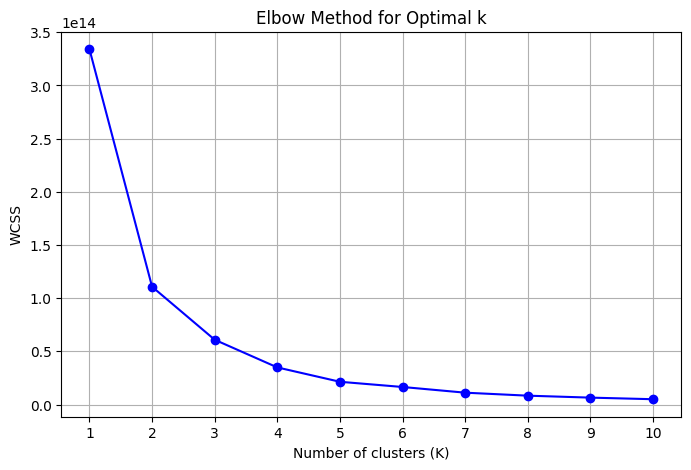

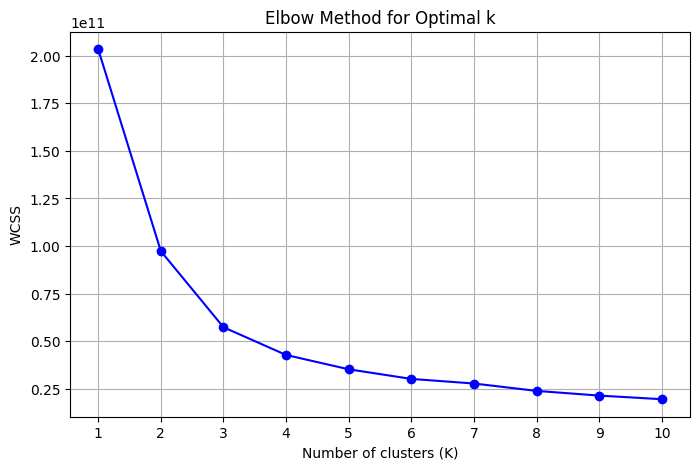

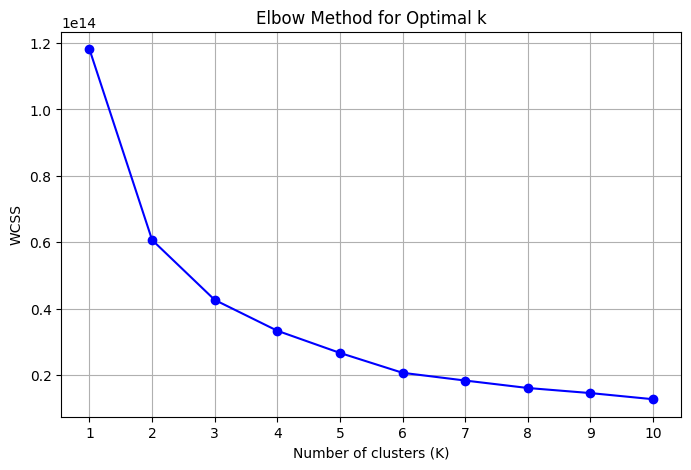

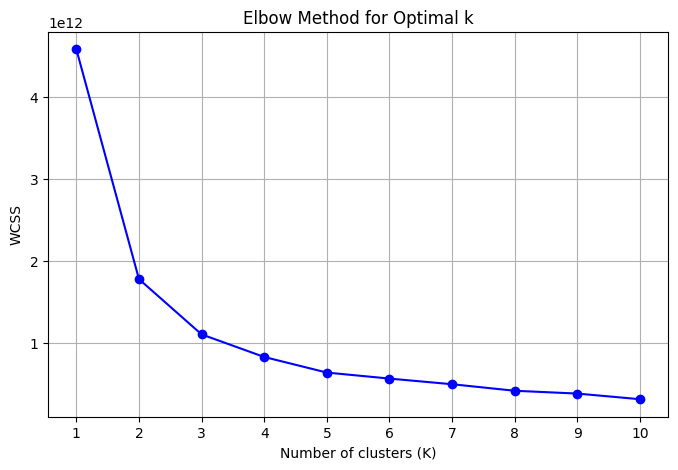

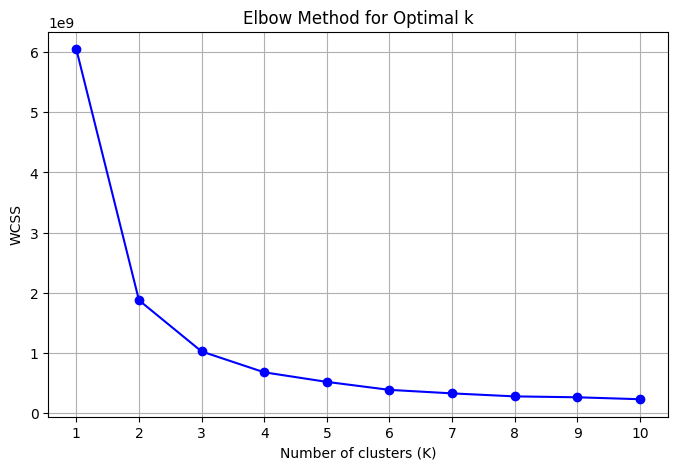

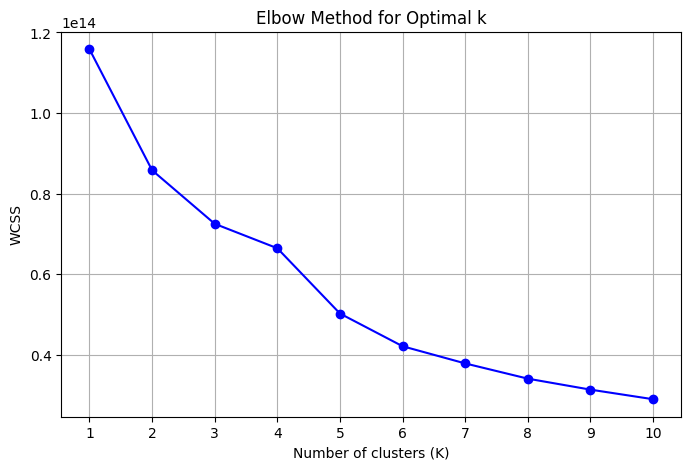

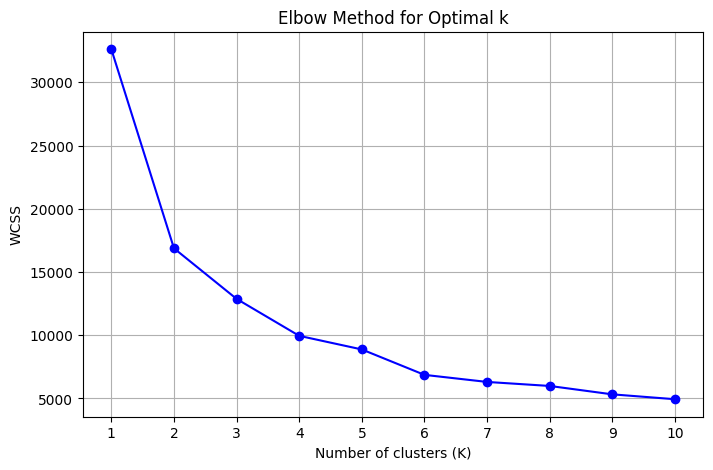

In [ ]:
#엘보우메서드 확인
elbow_method(merged_df,total_pop)
elbow_method(merged_df,minor_pop)
elbow_method(merged_df,adult_pop)
elbow_method(merged_df,old_pop)
elbow_method(merged_df,for_pop)

elbow_method(merged_df,potential)
elbow_method(merged_df,density)

#### K-Means, DBSCAN, MEAN-SHIFT간 비교


=== KMEANS ===
Silhouette Score: 0.696
 visualize_clustering 디버깅
method_name: kmeans
찾으려는 라벨 컬럼: kmeans_label
df 컬럼: ['역명', 'month', '총유동인구', 'kmeans_label']
[KMEANS] PCA 설명력: PC1=52.64%, PC2=47.36%


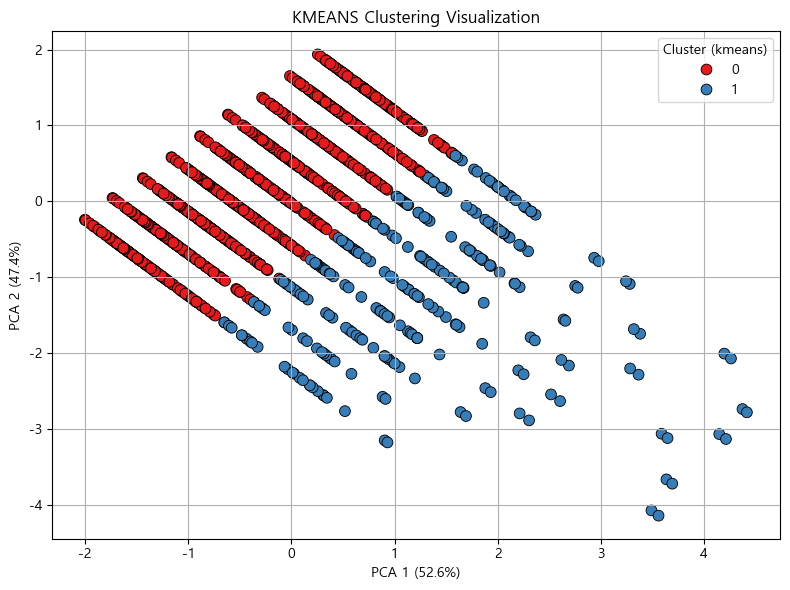

KMEANS Cluster Centers:
      총유동인구
0 -0.393763
1  1.697614
kmeans(total_population).csv 저장 완료.

=== MEANSHIFT ===
Silhouette Score: 0.647
 visualize_clustering 디버깅
method_name: meanshift
찾으려는 라벨 컬럼: meanshift_label
df 컬럼: ['역명', 'month', '총유동인구', 'meanshift_label']
[MEANSHIFT] PCA 설명력: PC1=52.64%, PC2=47.36%


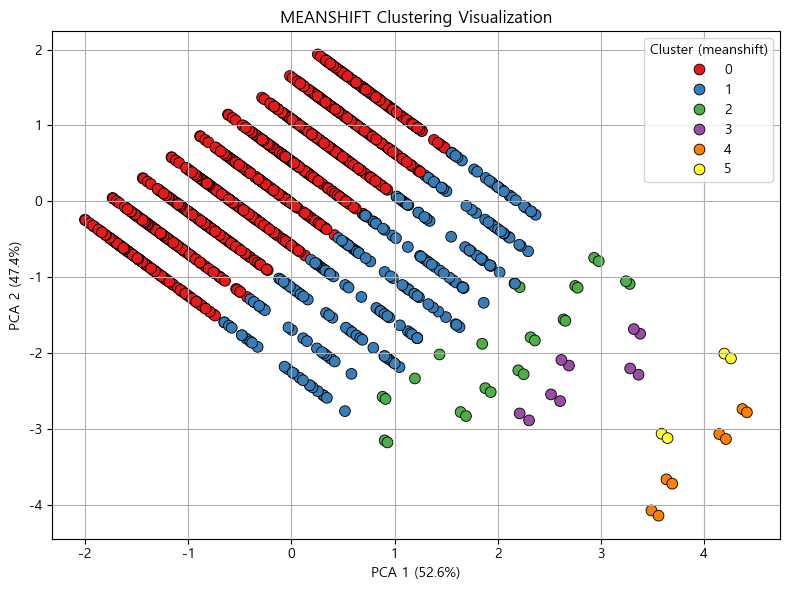

MEANSHIFT Cluster Centers:
      총유동인구
0 -0.515070
1  1.759273
2  2.963286
3  3.625530
4  5.150069
5  4.671688
meanshift(total_population).csv 저장 완료.

=== DBSCAN (Auto-Tuned) ===
유효한 DBSCAN 클러스터 조합이 없습니다.
DBSCAN: 유효한 클러스터 조합을 찾지 못했습니다.

=== KMEANS ===
Silhouette Score: 0.797
 visualize_clustering 디버깅
method_name: kmeans
찾으려는 라벨 컬럼: kmeans_label
df 컬럼: ['역명', 'month', '미성년_아침_유동인구', '미성년_점심_유동인구', '미성년_저녁_유동인구', 'kmeans_label']
[KMEANS] PCA 설명력: PC1=60.84%, PC2=24.96%


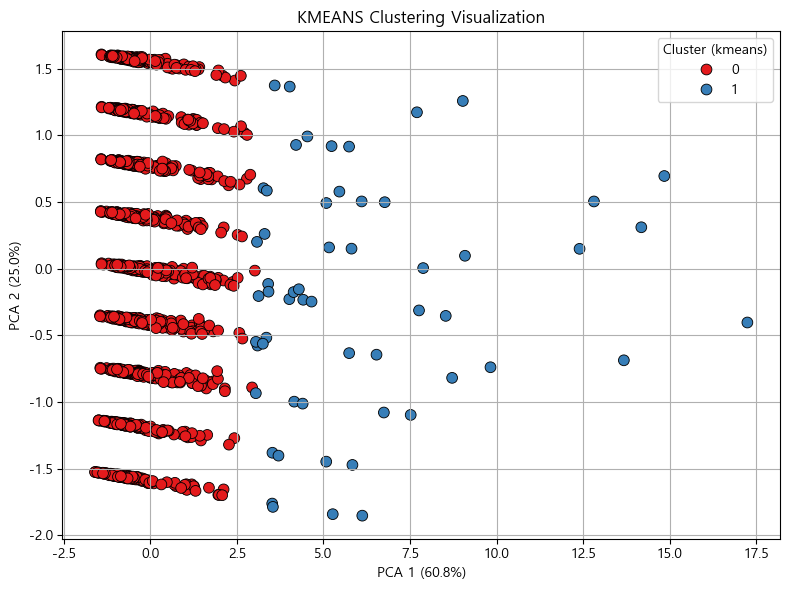

KMEANS Cluster Centers:
   미성년_아침_유동인구  미성년_점심_유동인구  미성년_저녁_유동인구
0    -0.101413    -0.140452    -0.144954
1     2.752387     3.811930     3.934095
kmeans(minor_population).csv 저장 완료.

=== MEANSHIFT ===
Silhouette Score: 0.535
 visualize_clustering 디버깅
method_name: meanshift
찾으려는 라벨 컬럼: meanshift_label
df 컬럼: ['역명', 'month', '미성년_아침_유동인구', '미성년_점심_유동인구', '미성년_저녁_유동인구', 'meanshift_label']
[MEANSHIFT] PCA 설명력: PC1=60.84%, PC2=24.96%


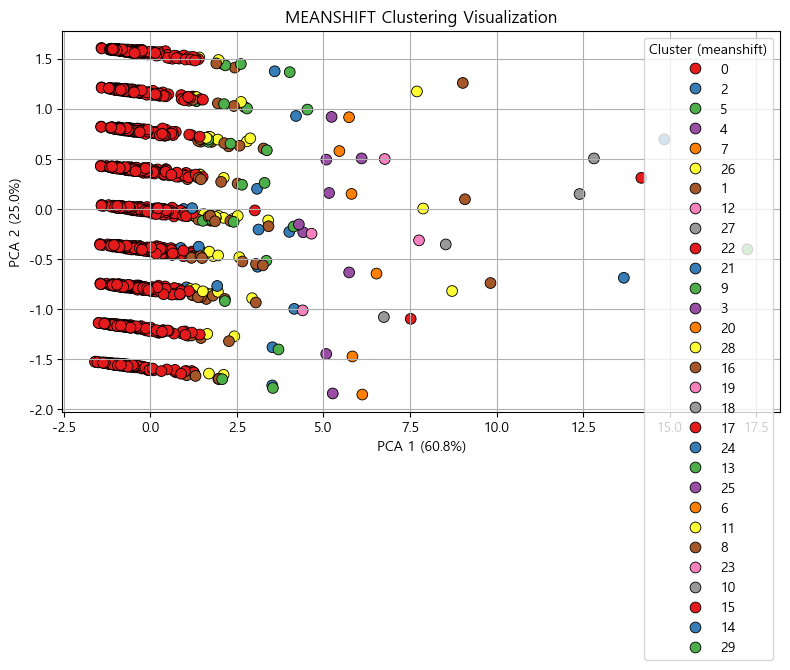

MEANSHIFT Cluster Centers:
    미성년_아침_유동인구  미성년_점심_유동인구  미성년_저녁_유동인구
0     -0.358315    -0.408394    -0.354474
1      0.519340     1.486851     2.870877
2      0.466375     1.966117     3.761187
3      2.368462     2.997743     4.205285
4      1.287085     2.965775     4.323601
5      0.336248     3.267099     2.009789
6      3.235047     3.998333     2.510447
7      2.425300     4.777977     2.907771
8      6.899789     5.158448     3.744729
9      2.586050     2.854286     2.036844
10     2.419934     7.914051    11.056006
11     2.071199     4.852264     6.320162
12     1.286883     3.591109     2.840224
13    17.570438     7.677341     5.471716
14    11.472847     8.678275     5.778754
15    10.621705     8.593184     5.531128
16     6.954439     5.972466     4.247154
17     5.129599     0.733857    -0.277631
18     4.671562     6.110826     3.936530
19     4.272235     3.968005     5.254966
20     4.175379     4.209724     2.990936
21     4.172132     0.051600    -0.498280
22     

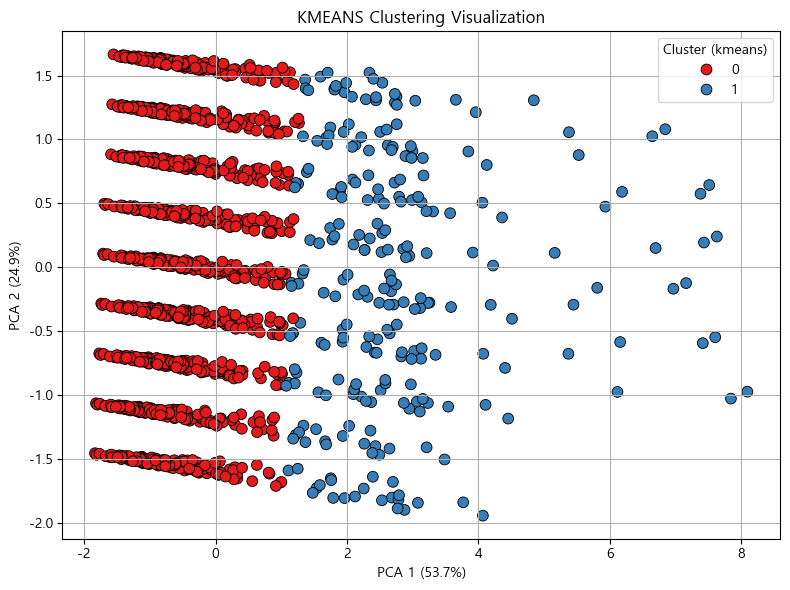

KMEANS Cluster Centers:
   성인_아침_유동인구  성인_점심_유동인구  성인_저녁_유동인구
0   -0.214872   -0.348268   -0.316837
1    1.163746    1.886222    1.715989
kmeans(adult_population).csv 저장 완료.

=== MEANSHIFT ===
Silhouette Score: 0.506
 visualize_clustering 디버깅
method_name: meanshift
찾으려는 라벨 컬럼: meanshift_label
df 컬럼: ['역명', 'month', '성인_아침_유동인구', '성인_점심_유동인구', '성인_저녁_유동인구', 'meanshift_label']
[MEANSHIFT] PCA 설명력: PC1=53.67%, PC2=24.85%


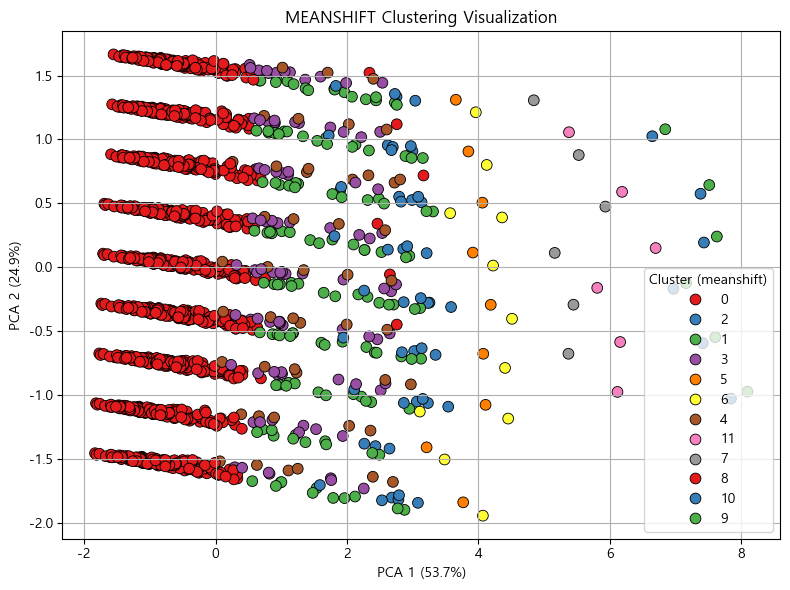

MEANSHIFT Cluster Centers:
    성인_아침_유동인구  성인_점심_유동인구  성인_저녁_유동인구
0    -0.429564   -0.535139   -0.447671
1    -0.280931    1.537880    2.065820
2     0.682727    1.933046    1.940906
3     1.805807    1.563774    0.440355
4     3.285651    0.993035   -0.068535
5     2.589391    2.205000    2.118147
6     0.949441    2.577323    3.429534
7     5.075826    3.322564    1.485527
8     5.055401    0.791958   -0.174608
9     3.495058    5.681785    3.519258
10    2.531009    4.861358    4.835576
11    0.278708    4.242928    5.140463
meanshift(adult_population).csv 저장 완료.

=== DBSCAN (Auto-Tuned) ===
Best eps: 1.8, min_samples: 4.0, silhouette: 0.735
 visualize_clustering 디버깅
method_name: dbscan
찾으려는 라벨 컬럼: dbscan_label
df 컬럼: ['역명', 'month', '성인_아침_유동인구', '성인_점심_유동인구', '성인_저녁_유동인구', 'dbscan_label']
[DBSCAN] PCA 설명력: PC1=53.67%, PC2=24.85%


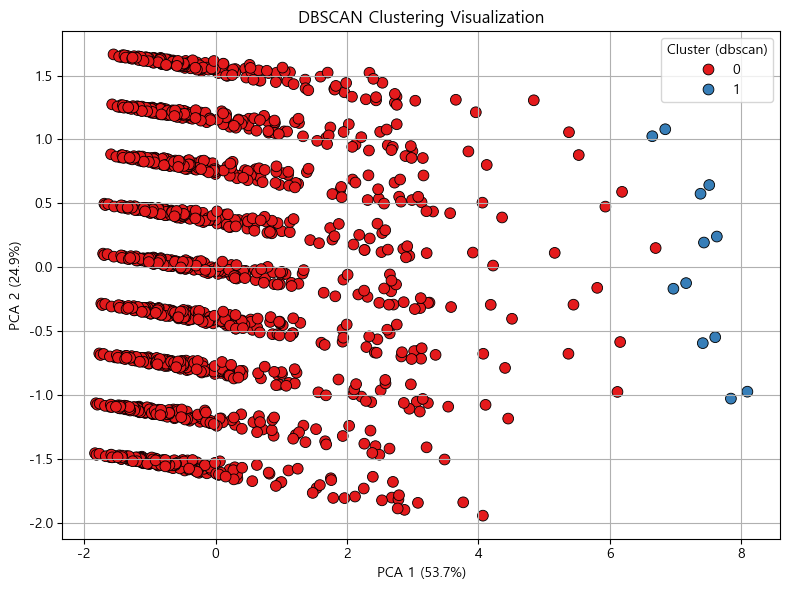

Silhouette Score (excluding noise): 0.735
DBSCAN 클러스터 수: 2
dbscan(adult_population).csv 저장 완료.

=== KMEANS ===
Silhouette Score: 0.607
 visualize_clustering 디버깅
method_name: kmeans
찾으려는 라벨 컬럼: kmeans_label
df 컬럼: ['역명', 'month', '노인_아침_유동인구', '노인_점심_유동인구', '노인_저녁_유동인구', 'kmeans_label']
[KMEANS] PCA 설명력: PC1=57.44%, PC2=25.06%


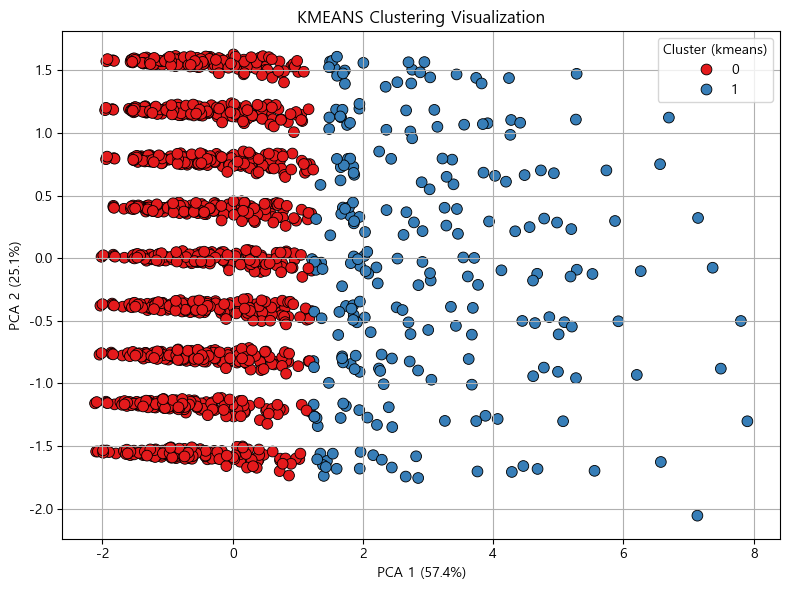

KMEANS Cluster Centers:
   노인_아침_유동인구  노인_점심_유동인구  노인_저녁_유동인구
0   -0.266957   -0.332513   -0.265066
1    1.562952    1.946762    1.551880
kmeans(old_population).csv 저장 완료.

=== MEANSHIFT ===
Silhouette Score: 0.417
 visualize_clustering 디버깅
method_name: meanshift
찾으려는 라벨 컬럼: meanshift_label
df 컬럼: ['역명', 'month', '노인_아침_유동인구', '노인_점심_유동인구', '노인_저녁_유동인구', 'meanshift_label']
[MEANSHIFT] PCA 설명력: PC1=57.44%, PC2=25.06%


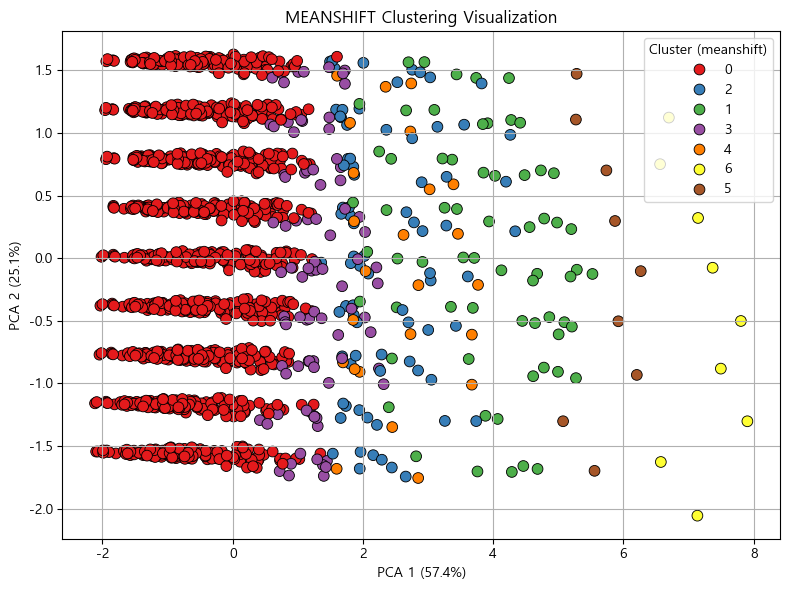

MEANSHIFT Cluster Centers:
   노인_아침_유동인구  노인_점심_유동인구  노인_저녁_유동인구
0   -0.513687   -0.556694   -0.469924
1    2.571026    2.501318    2.446451
2    1.253397    2.090752    2.373394
3   -0.449853    2.251947    0.526205
4    0.518262    2.627384    1.730514
5    4.536834    4.812485    0.432091
6    0.294095    4.961700    6.846921
meanshift(old_population).csv 저장 완료.

=== DBSCAN (Auto-Tuned) ===
Best eps: 2.5, min_samples: 4.0, silhouette: 0.773
 visualize_clustering 디버깅
method_name: dbscan
찾으려는 라벨 컬럼: dbscan_label
df 컬럼: ['역명', 'month', '노인_아침_유동인구', '노인_점심_유동인구', '노인_저녁_유동인구', 'dbscan_label']
[DBSCAN] PCA 설명력: PC1=57.44%, PC2=25.06%


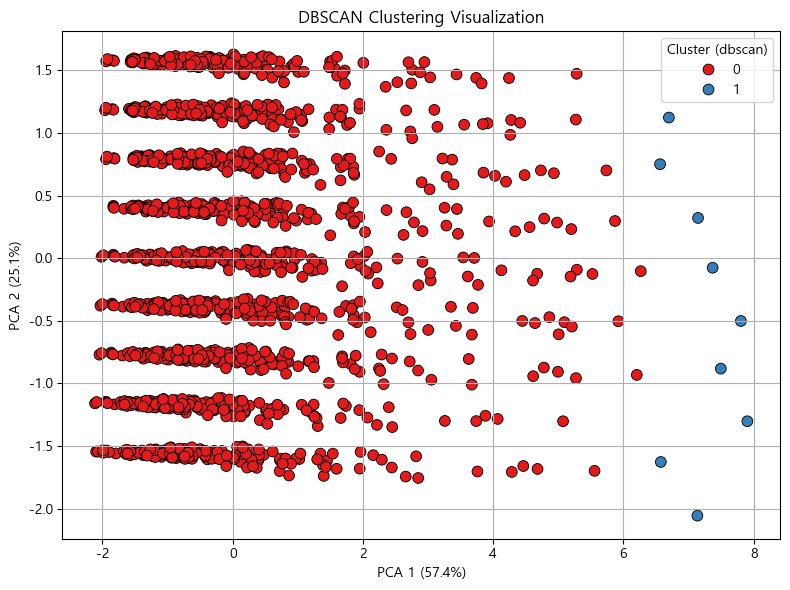

Silhouette Score (excluding noise): 0.773
DBSCAN 클러스터 수: 2
dbscan(old_population).csv 저장 완료.

=== KMEANS ===
Silhouette Score: 0.841
 visualize_clustering 디버깅
method_name: kmeans
찾으려는 라벨 컬럼: kmeans_label
df 컬럼: ['역명', 'month', '외국인_아침_유동인구', '외국인_점심_유동인구', '외국인_저녁_유동인구', 'kmeans_label']
[KMEANS] PCA 설명력: PC1=65.64%, PC2=24.84%


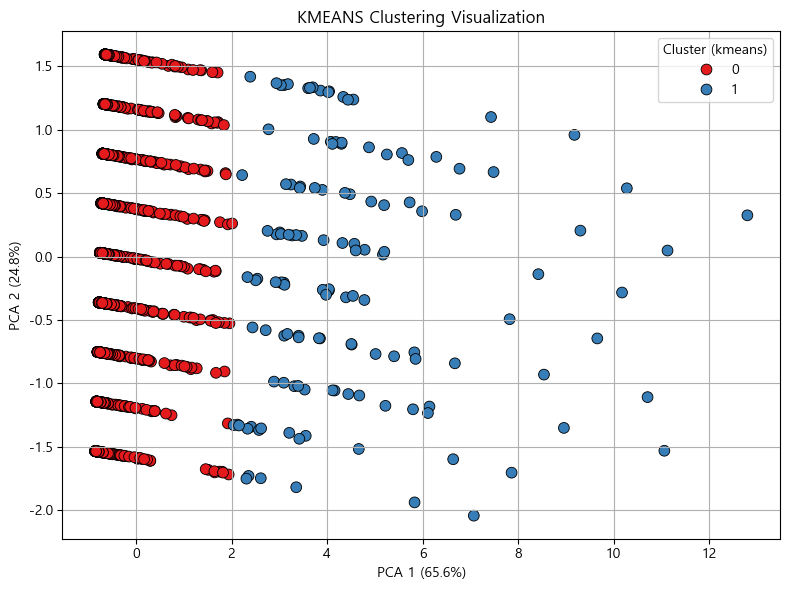

KMEANS Cluster Centers:
   외국인_아침_유동인구  외국인_점심_유동인구  외국인_저녁_유동인구
0    -0.234010    -0.255306    -0.235473
1     2.588189     2.823728     2.604364
kmeans(foreign_population).csv 저장 완료.

=== MEANSHIFT ===
Silhouette Score: 0.754
 visualize_clustering 디버깅
method_name: meanshift
찾으려는 라벨 컬럼: meanshift_label
df 컬럼: ['역명', 'month', '외국인_아침_유동인구', '외국인_점심_유동인구', '외국인_저녁_유동인구', 'meanshift_label']
[MEANSHIFT] PCA 설명력: PC1=65.64%, PC2=24.84%


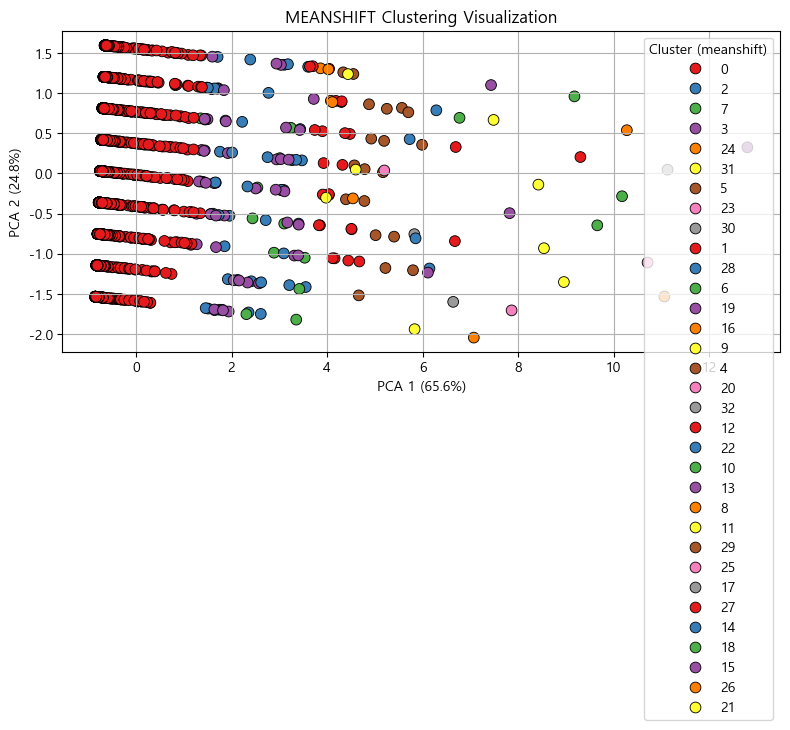

MEANSHIFT Cluster Centers:
    외국인_아침_유동인구  외국인_점심_유동인구  외국인_저녁_유동인구
0     -0.337386    -0.394789    -0.353911
1      1.328199     2.430248     3.232671
2      1.030718     1.926120     2.623847
3      2.191067     2.154796     1.101974
4      5.726499     2.528577     1.307023
5      4.334206     2.484499     1.376643
6      1.716882     2.845319     0.266837
7      3.462284     1.675597     0.864724
8      2.766415     3.478154     0.744461
9      2.487177     5.621643     6.440275
10     5.757186     5.306308     5.689201
11     4.922811     1.739400     0.935983
12     5.106003     4.980203     1.470385
13     2.221290     5.193854     5.622896
14     0.382327     3.426527     6.421755
15     8.294428     7.122880     6.735446
16     7.626928     5.844872     5.910522
17     6.774753     6.414391     6.067825
18     6.741378     3.428475     1.592020
19     6.663503     2.621278     1.586532
20     6.583403     5.572126     6.549792
21     6.113928     5.179243     1.581045
22     

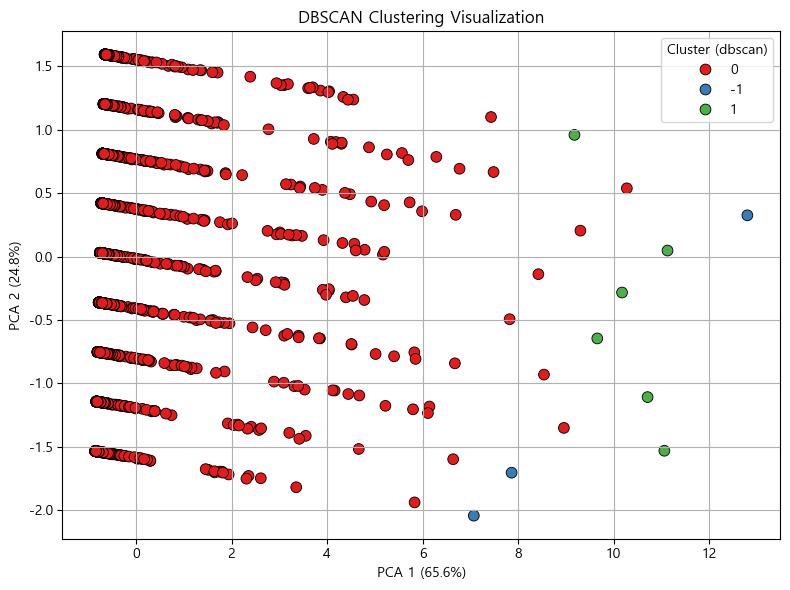

Silhouette Score (excluding noise): 0.863
DBSCAN 클러스터 수: 2
dbscan(foreign_population).csv 저장 완료.

=== KMEANS ===
Silhouette Score: 0.514
 visualize_clustering 디버깅
method_name: kmeans
찾으려는 라벨 컬럼: kmeans_label
df 컬럼: ['역명', 'month', '평균면적당 임대료_공유오피스', '평균면적당 임대료_무인프린트', '평균면적당 임대료_밀키트', '평균면적당 임대료_사무실', '평균면적당 임대료_식음료', '평균면적당 임대료_의약업', '평균면적당 임대료_패션잡화', '평균면적당 임대료_편의점', '평균면적당 임대료_플라워', '평균면적당 임대료_화상면접', '평균면적당 임대료_화장품', 'kmeans_label']
[KMEANS] PCA 설명력: PC1=25.30%, PC2=11.67%


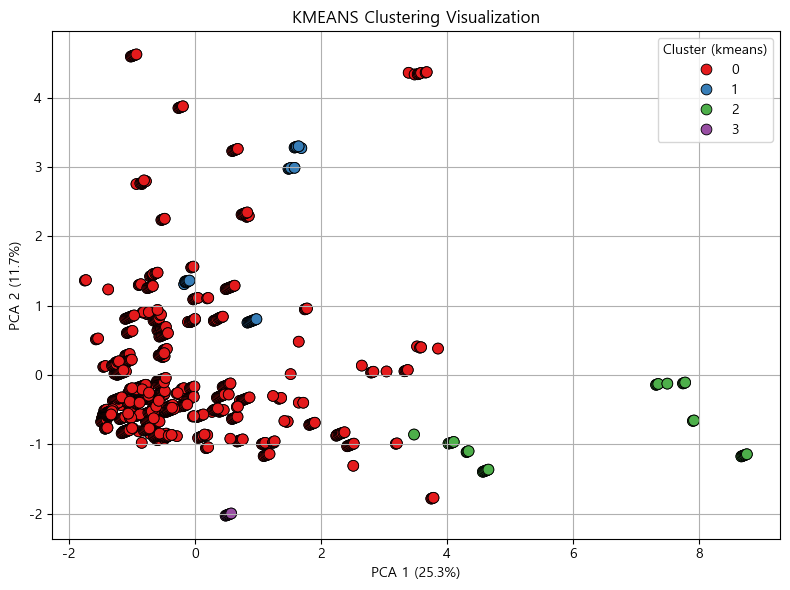

KMEANS Cluster Centers:
   평균면적당 임대료_공유오피스  평균면적당 임대료_무인프린트  평균면적당 임대료_밀키트  평균면적당 임대료_사무실  \
0        -0.176929         0.002923       0.016640       0.004084   
1         5.103756         0.357531      -0.195186       0.375874   
2        -0.195868        -0.328152      -0.195186      -0.365741   
3        -0.195868        -0.328152      -0.195186      -0.365741   

   평균면적당 임대료_식음료  평균면적당 임대료_의약업  평균면적당 임대료_패션잡화  평균면적당 임대료_편의점  평균면적당 임대료_플라워  \
0      -0.089881      -0.130640       -0.124843       0.031725      -0.108727   
1       0.147139      -0.357211        0.646697      -0.305176      -0.097212   
2       2.271627       3.611030        2.663685      -0.450191       0.910668   
3      -0.949967      -0.357211       -0.852090      -0.283180       9.275612   

   평균면적당 임대료_화상면접  평균면적당 임대료_화장품  
0             0.0      -0.184310  
1             0.0       0.700669  
2             0.0       3.996007  
3             0.0      -0.432152  
kmeans(potential).csv 저장 완료.

=== MEANSHIFT ===
S

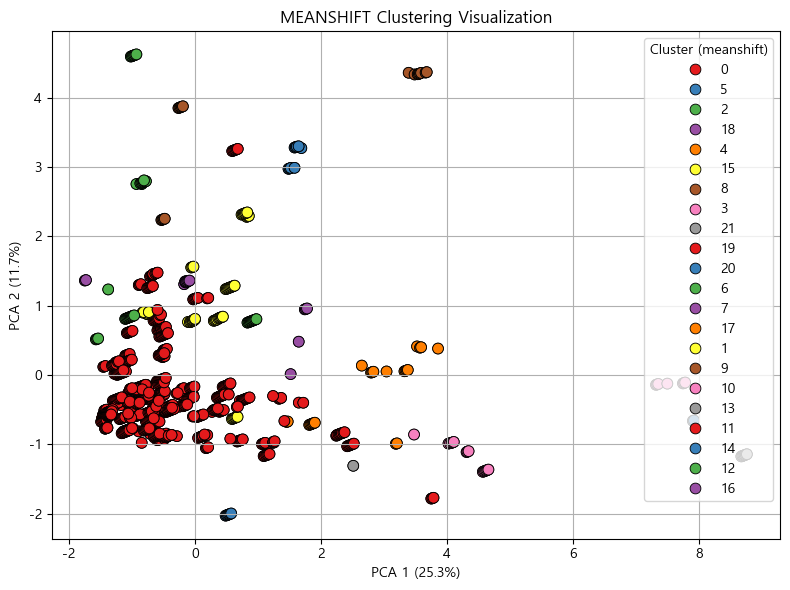

MEANSHIFT Cluster Centers:
    평균면적당 임대료_공유오피스  평균면적당 임대료_무인프린트  평균면적당 임대료_밀키트  평균면적당 임대료_사무실  \
0         -0.195868        -0.216645      -0.195186      -0.199921   
1         -0.195868         0.888290      -0.195186       2.075895   
2         -0.195868         0.550044       3.446132      -0.365741   
3         -0.195868        -0.328152      -0.195186      -0.365741   
4         -0.195868        -0.328152      -0.195186      -0.365741   
5          6.269615         1.728898      -0.195186      -0.365741   
6          5.421142        -0.328152      -0.195186      -0.365741   
7          3.620512        -0.328152      -0.195186       1.859102   
8         -0.195868         0.959138       6.908658      -0.365741   
9         -0.195868         6.435842      -0.195186      -0.365741   
10        -0.195868        -0.328152      -0.195186      -0.365741   
11        -0.195868         4.384496      -0.195186      -0.365741   
12        -0.195868         2.593162      -0.195186       7.005

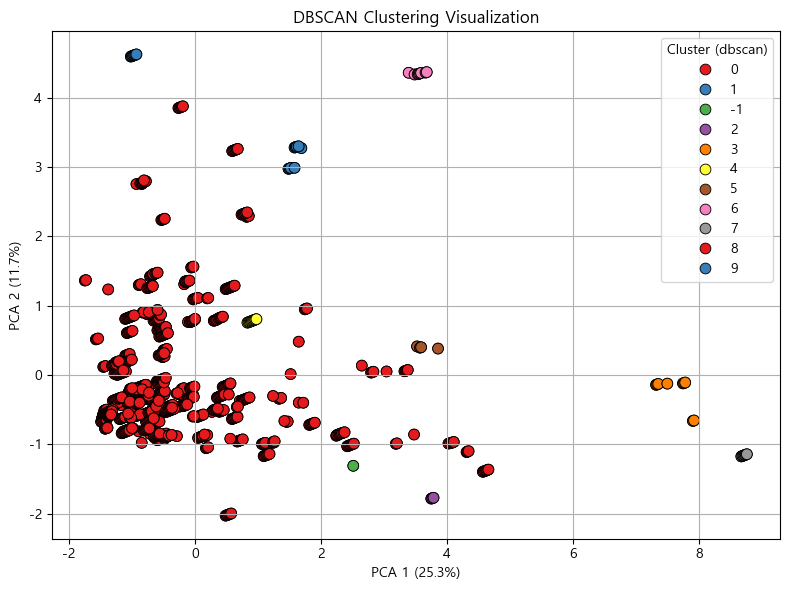

Silhouette Score (excluding noise): 0.525
DBSCAN 클러스터 수: 10
dbscan(potential).csv 저장 완료.

=== KMEANS ===
Silhouette Score: 0.440
 visualize_clustering 디버깅
method_name: kmeans
찾으려는 라벨 컬럼: kmeans_label
df 컬럼: ['역명', 'month', '점포수_공유오피스', '점포수_무인프린트', '점포수_밀키트', '점포수_사무실', '점포수_식음료', '점포수_의약업', '점포수_패션잡화', '점포수_편의점', '점포수_플라워', '점포수_화상면접', '점포수_화장품', 'kmeans_label']
[KMEANS] PCA 설명력: PC1=23.45%, PC2=12.21%


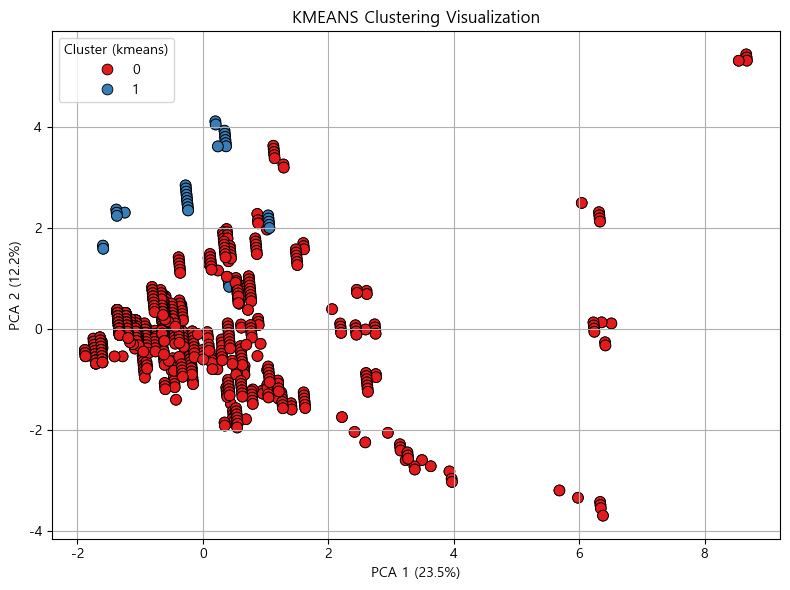

KMEANS Cluster Centers:
   점포수_공유오피스  점포수_무인프린트   점포수_밀키트   점포수_사무실   점포수_식음료  점포수_의약업  점포수_패션잡화  \
0   0.006386  -0.031934 -0.207154  0.014921  0.023009 -0.01152 -0.001765   
1  -0.148807   0.744158  4.827321 -0.347705 -0.536173  0.26844  0.041136   

    점포수_편의점   점포수_플라워  점포수_화상면접   점포수_화장품  
0 -0.003698  0.012396       0.0 -0.016685  
1  0.086176 -0.288866       0.0  0.388800  
kmeans(density).csv 저장 완료.

=== MEANSHIFT ===
Silhouette Score: 0.396
 visualize_clustering 디버깅
method_name: meanshift
찾으려는 라벨 컬럼: meanshift_label
df 컬럼: ['역명', 'month', '점포수_공유오피스', '점포수_무인프린트', '점포수_밀키트', '점포수_사무실', '점포수_식음료', '점포수_의약업', '점포수_패션잡화', '점포수_편의점', '점포수_플라워', '점포수_화상면접', '점포수_화장품', 'meanshift_label']
[MEANSHIFT] PCA 설명력: PC1=23.45%, PC2=12.21%


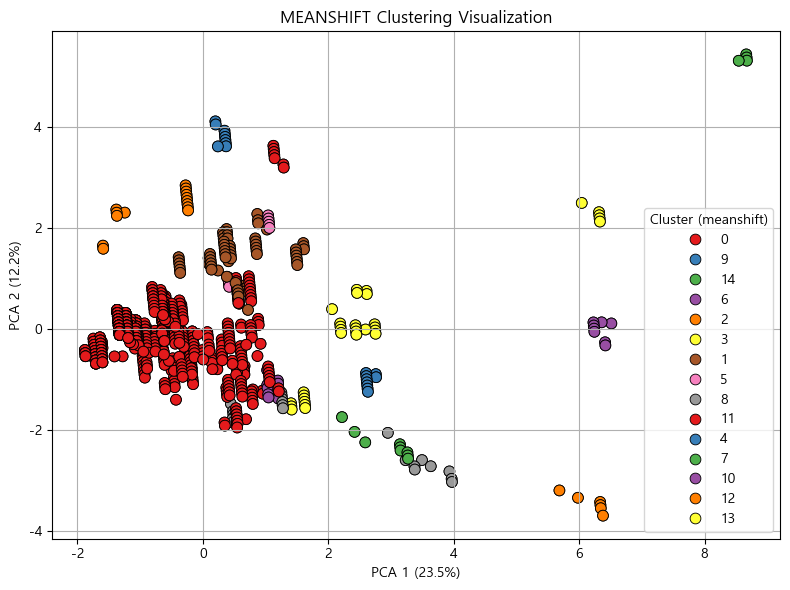

MEANSHIFT Cluster Centers:
    점포수_공유오피스  점포수_무인프린트   점포수_밀키트   점포수_사무실   점포수_식음료   점포수_의약업  점포수_패션잡화  \
0   -0.148807  -0.384951 -0.207154 -0.174895 -0.319608 -0.223983 -0.371856   
1   -0.001360   2.276521 -0.207154  0.200332 -0.113491 -0.437039  0.283635   
2   -0.148807  -0.384951  4.827321 -0.347705 -0.583310 -0.437039 -0.763029   
3    1.944931  -0.384951 -0.207154  1.273572  0.552462 -0.437039  1.656341   
4   -0.148807   2.276521  4.827321 -0.347705 -0.682073 -0.437039  0.350431   
5   -0.148807   1.093644  4.827321 -0.347705 -0.311712  2.149718  1.072118   
6   -0.148807  -0.384951 -0.207154  6.857973  1.046276 -0.437039 -0.268158   
7   -0.148807  -0.384951 -0.207154 -0.347705  4.214917 -0.437039  1.931269   
8   -0.148807  -0.384951 -0.207154 -0.347705  2.363114  2.006009  3.855768   
9   -0.148807  -0.384951 -0.207154 -0.347705  1.252032  2.149718 -0.474354   
10  -0.148807   2.276521 -0.207154 -0.347705  1.308615  4.736475  2.077325   
11  -0.148807   4.937993 -0.207154 -0

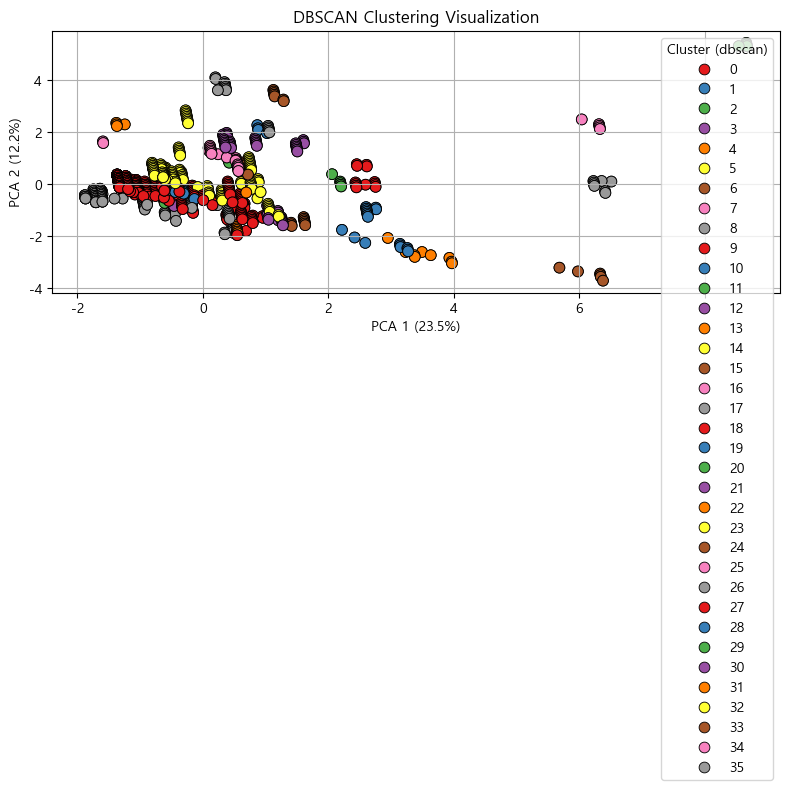

Silhouette Score (excluding noise): 0.455
DBSCAN 클러스터 수: 36
dbscan(density).csv 저장 완료.


In [51]:
#함수 호출,
clustering_result(merged_df,total_pop,2,"total_population")
clustering_result(merged_df,minor_pop,2,"minor_population")
clustering_result(merged_df,adult_pop,2,"adult_population")
clustering_result(merged_df,old_pop,2,"old_population")
clustering_result(merged_df,for_pop,2,"foreign_population")
clustering_result(merged_df,potential,4,"potential")
clustering_result(merged_df,density,2,"density")

#### **각 군집별 성능비교 후 선택**

- #총유동인구
- kmeans 0.696
- meanshift 0.647
- dbscan --   
---------------                
- #미성년 유동인구
- kmeans 0.797
- meanshift 0.535
- dbscan --
----------------
- #성인유동인구
- kmeans 0.621
- meanshift 0.506
- dbscan 0.735
----------------
- #노인유동인구
- kmeans 0.607
- meanshift 0.417
- dbscan 0.773
----------------
- #외국인유동인구
- kmeans 0.841
- meanshift 0.754
- dbscan 0.863
----------------
- #업종별잠재수익
- kmeans 0.514
- meanshift 0.406
- dbscan 0.525 / 10
---------------
- #업종별밀집도
- kmeans 0.440
- meanshift 0.396
- dbscan 0.455/군집과다

### **3.군집별 특성 분석**

#### 선택 모델
- 총유동인구분포 : kmeans
- 미성년자 유동인구분포 : kmeans
- 성인유동인구분포: dbscan
- 노인유동인구분포: dbscan
- 외국인유동인구분포: dbscan
- 업종별 잠재수익: dbscan
- 업종별밀집도 kmeans (dbscan 군집과다)

In [ ]:
#파일 읽어오기
total_pop_df = pd.read_csv("kmeans(total_population).csv",encoding='utf-8-sig')
minor_pop_df = pd.read_csv("kmeans(minor_population).csv",encoding = 'utf-8-sig')
adult_pop_df = pd.read_csv("dbscan(adult_population).csv",encoding = 'utf-8-sig')
old_pop_df = pd.read_csv("dbscan(old_population).csv",encoding = 'utf-8-sig')
for_pop_df = pd.read_csv("dbscan(foreign_population).csv",encoding = 'utf-8-sig')

potential_df = pd.read_csv("dbscan(potential).csv",encoding = 'utf-8-sig')

density_df = pd.read_csv("kmeans(density).csv",encoding = 'utf-8-sig')

#### 군집별 특성 분석 계획

- 군집의 라벨을 바탕으로 groupby하고 평균을 구한 후 표준화합니다.
- 그 다음, 군집별로 수치를 비교해 특성을 분석합니다.



#### 총 유동인구 군집



In [26]:
grouped_tot = total_pop_df.drop(columns=['역명','month'])
grouped_tot = grouped_tot.groupby('kmeans_label').mean()
grouped_tot.to_csv('total_population_characteristic.csv', encoding='utf-8-sig')

#### 미성년 유동인구 군집


In [27]:
grouped_min = minor_pop_df.drop(columns=['역명','month'])
grouped_min = grouped_min.groupby('kmeans_label').mean()
grouped_min.to_csv('minor_population_characteristic.csv', encoding = 'utf-8-sig')

#### 성인 유동인구 군집

In [29]:
grouped_adt = adult_pop_df.drop(columns=['역명','month'])
grouped_adt = grouped_adt.groupby('dbscan_label').mean()
grouped_adt.to_csv("adult_population_characteristic.csv", encoding = 'utf-8-sig')

#### 노인 유동인구 군집

In [30]:
grouped_old = old_pop_df.drop(columns=['역명','month'])
grouped_old = grouped_old.groupby('dbscan_label').mean()
grouped_old.to_csv("old_population_characteristic.csv",encoding='utf-8-sig')


#### 외국인 유동인구 군집

In [31]:
grouped_for = for_pop_df.drop(columns=['역명','month'])
grouped_for = grouped_for.groupby('dbscan_label').mean()
grouped_for.to_csv("foreign_population_characteristic.csv",encoding='utf-8-sig')

#### 업종별 잠재수익 특성

In [32]:
grouped_pot = potential_df.drop(columns=['역명','month'])
grouped_pot = grouped_pot.groupby('dbscan_label').mean()
grouped_pot.to_csv("potential_characteristic.csv",encoding='utf-8-sig')

#### 업종별 밀집도 특성

In [33]:
grouped_den = density_df.drop(columns=['역명','month'])
grouped_den = grouped_den.groupby('kmeans_label').mean()
grouped_den.to_csv("density_characteristic.csv",encoding='utf-8-sig')

#### 군집별 특성 파악.



- //미성년 유동인구 클러스터 특성
- 0:미성년 유동인구 적음
- 1.미성년 유동인구 많음
----------
- ///노인 유동인구 클러스터 특성
- 0: 노인 유동인구 적음
- 1: 노인 유동인구 많음
----------
- //성인 유동인구 클러스터 특성
- 0:성인 유동인구 많음
- 1:성인 유동인구 적음
----------
- //외국인 유동인구 클러스터 특성
- -1:외국인 유동인구 중간, 밀도 낮아 군집화 실패
- 0: 외국인 유동인구 적음
- 1.외국인 유동인구 많음
----------
- //총유동인구 클러스터 특성
- 0:총유동인구 적음
- 1:총유동인구 많음

#### 업종별 잠재수익 특성
- 시각화를 통해 상위 3개 업종씩 피쳐로 뽑겠습니다.

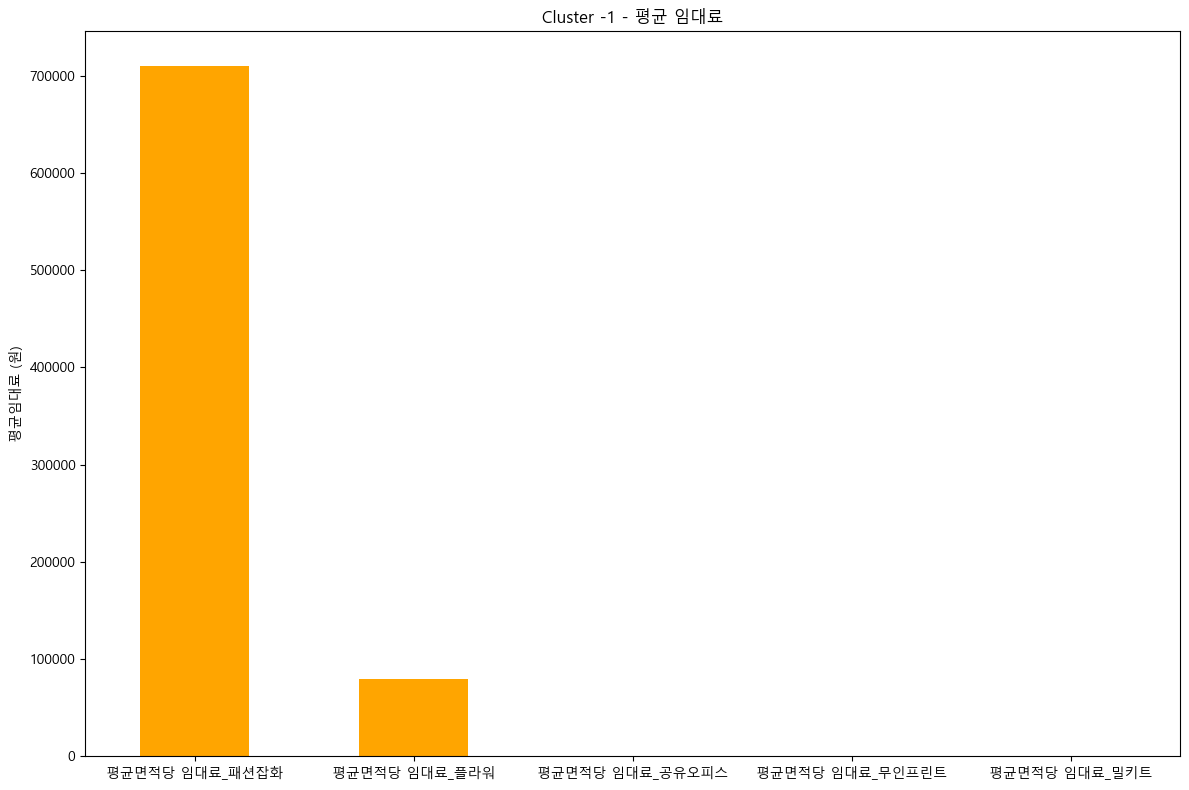

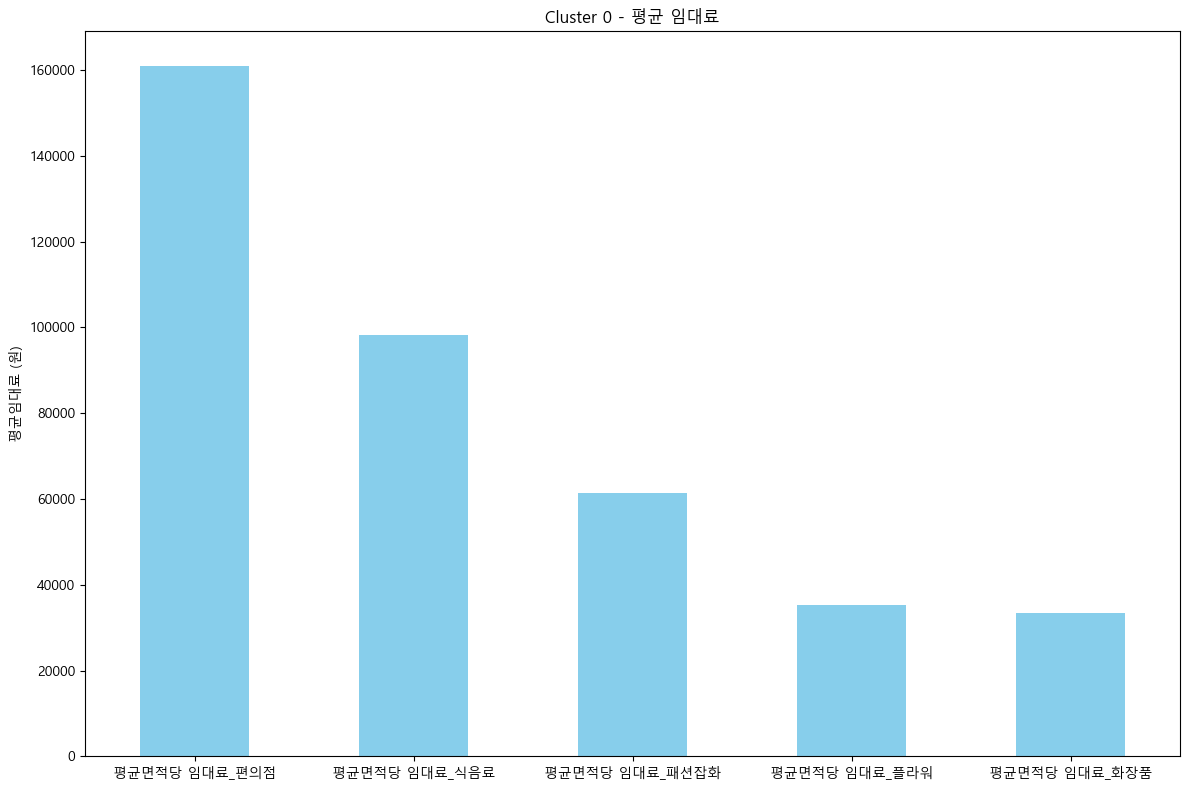

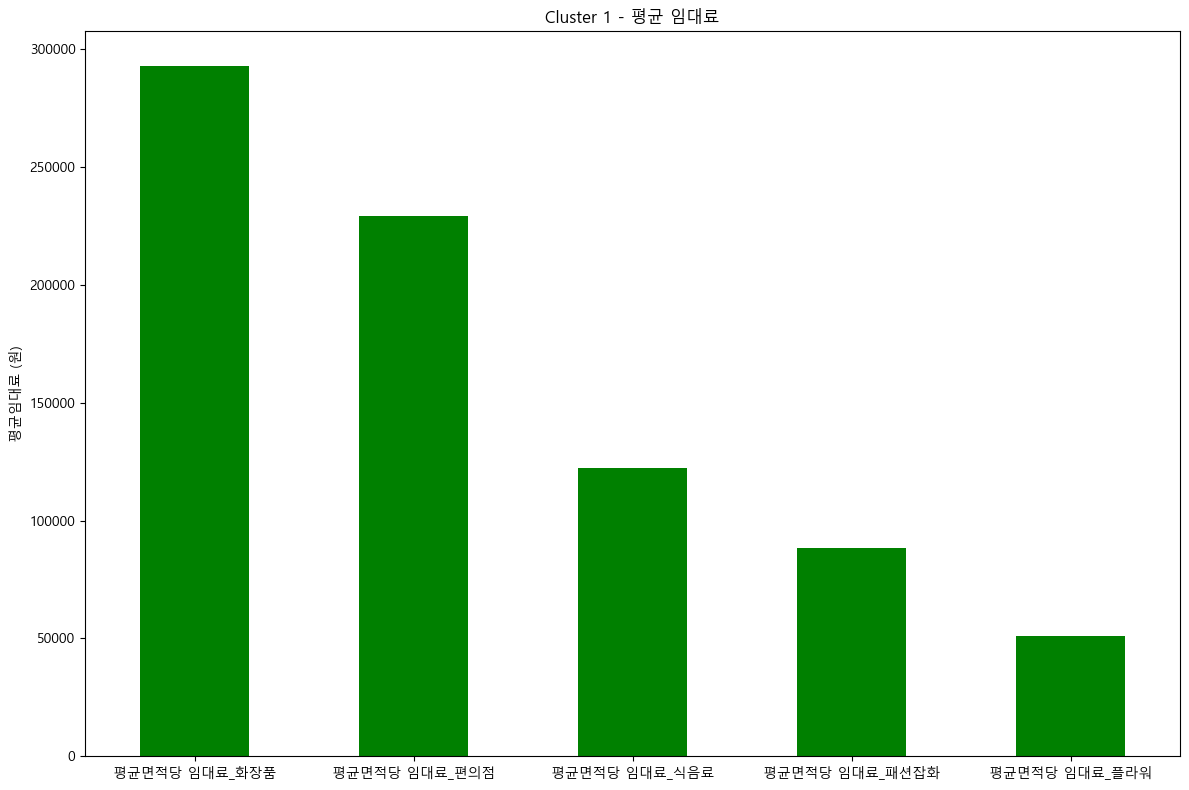

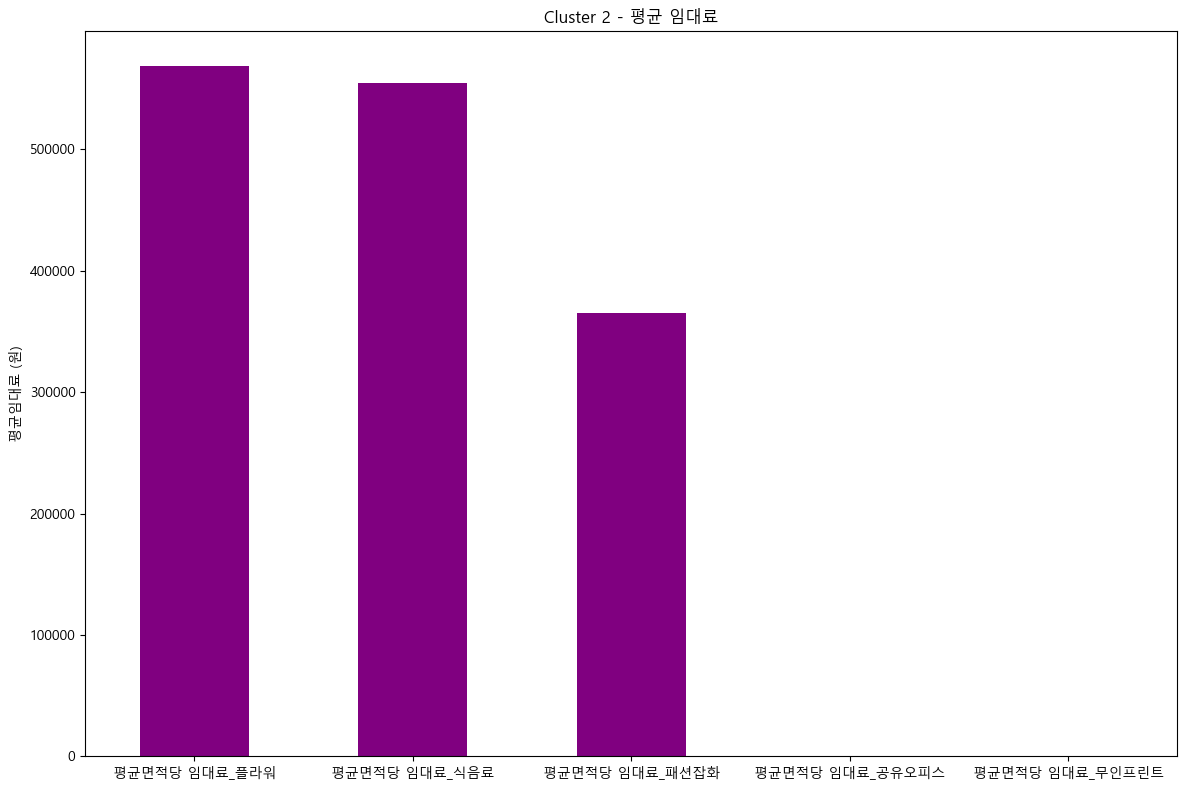

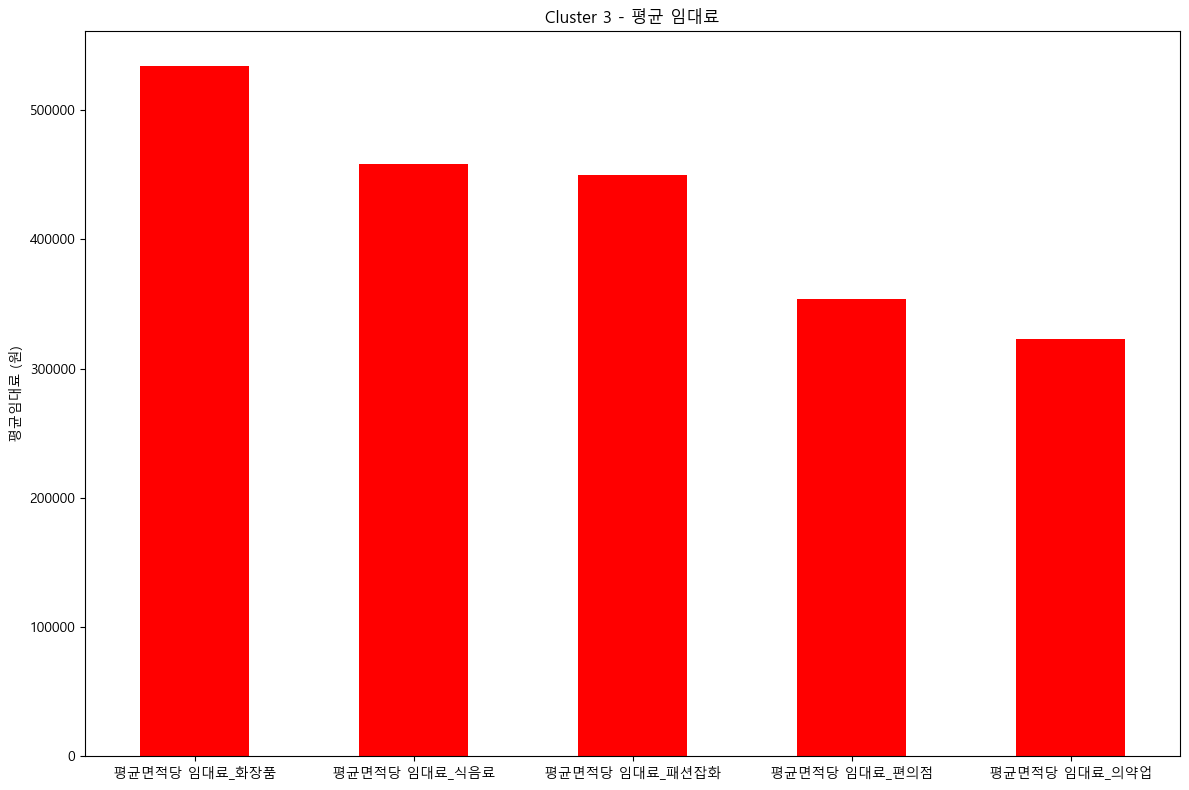

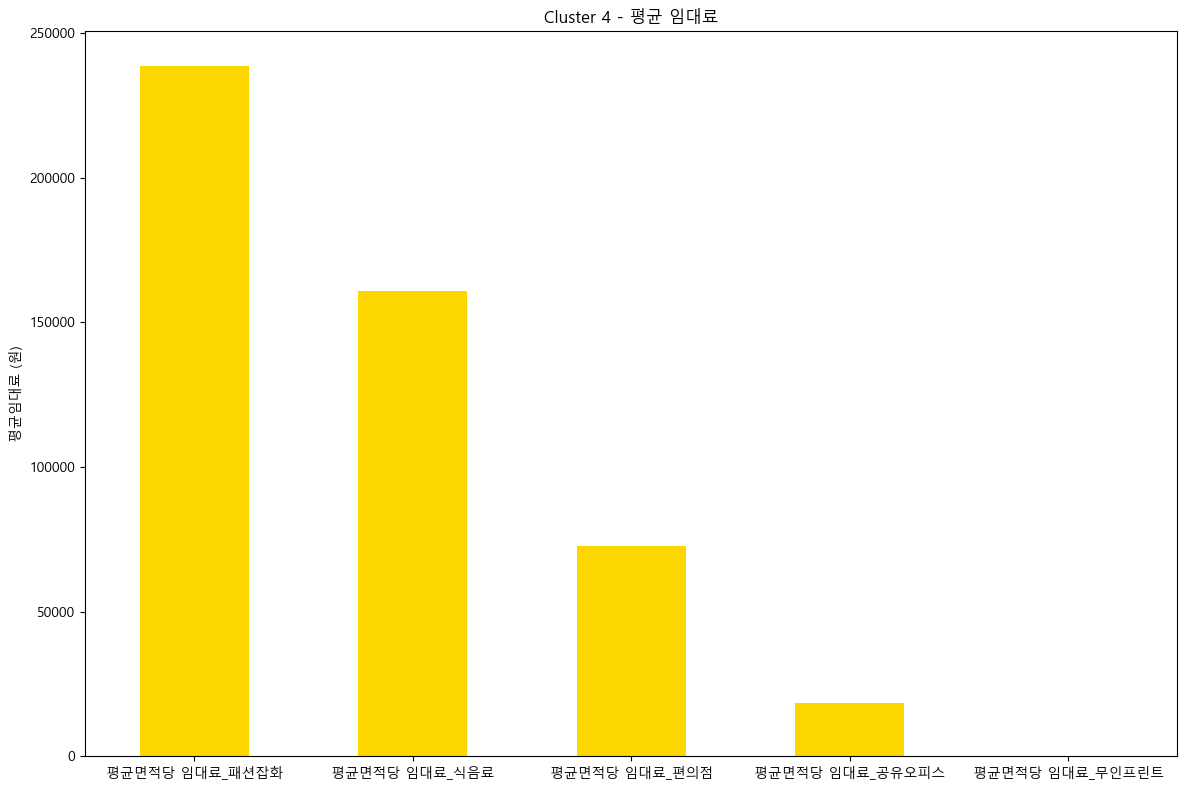

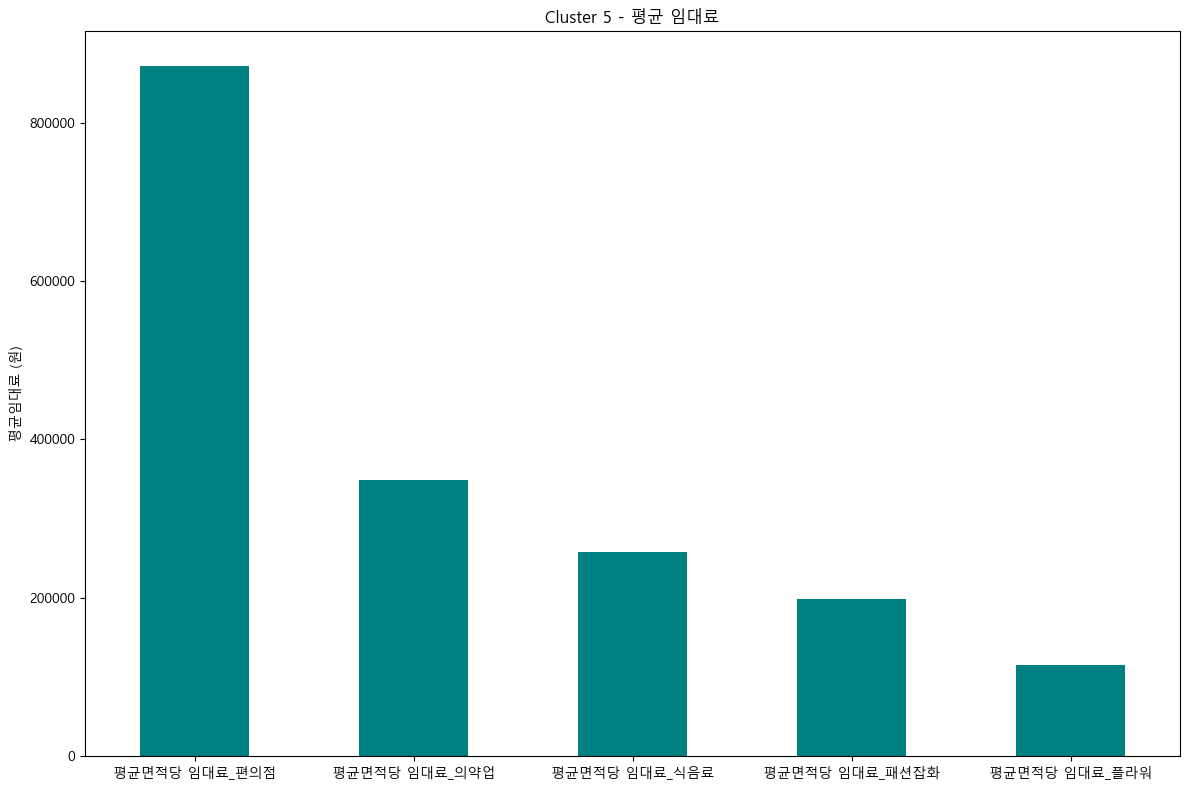

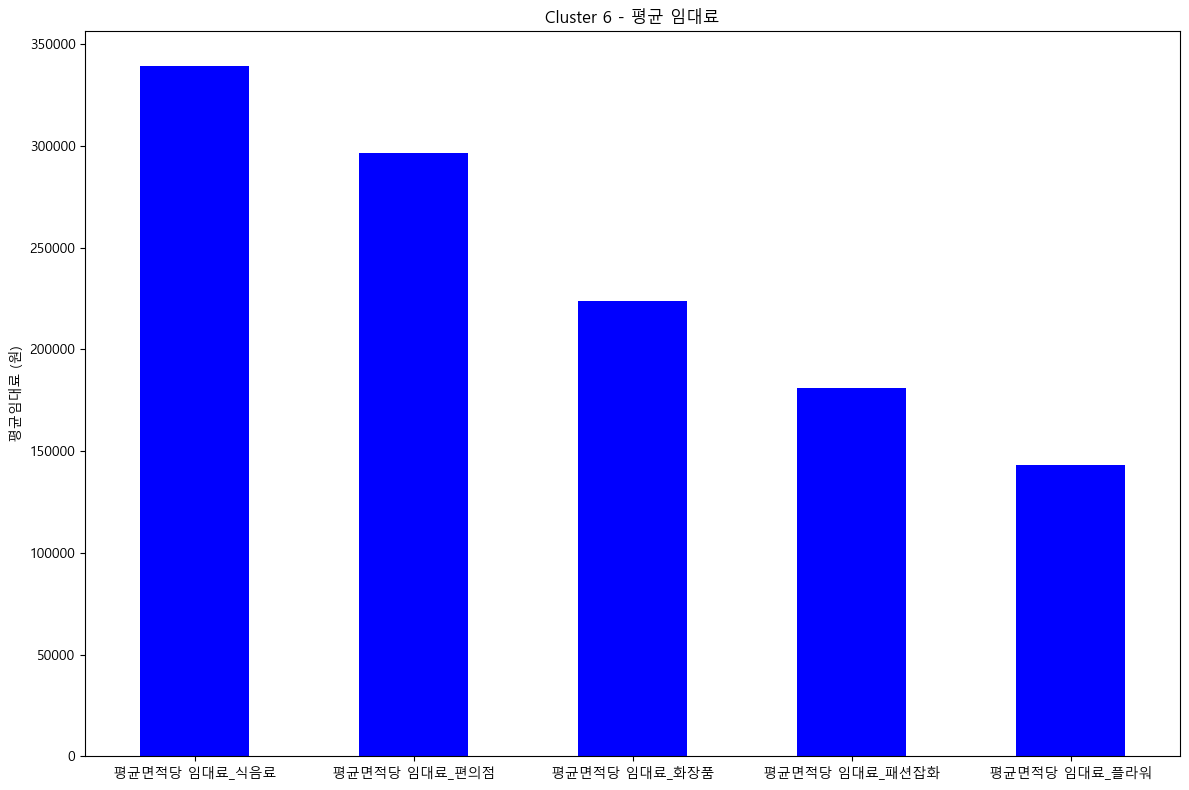

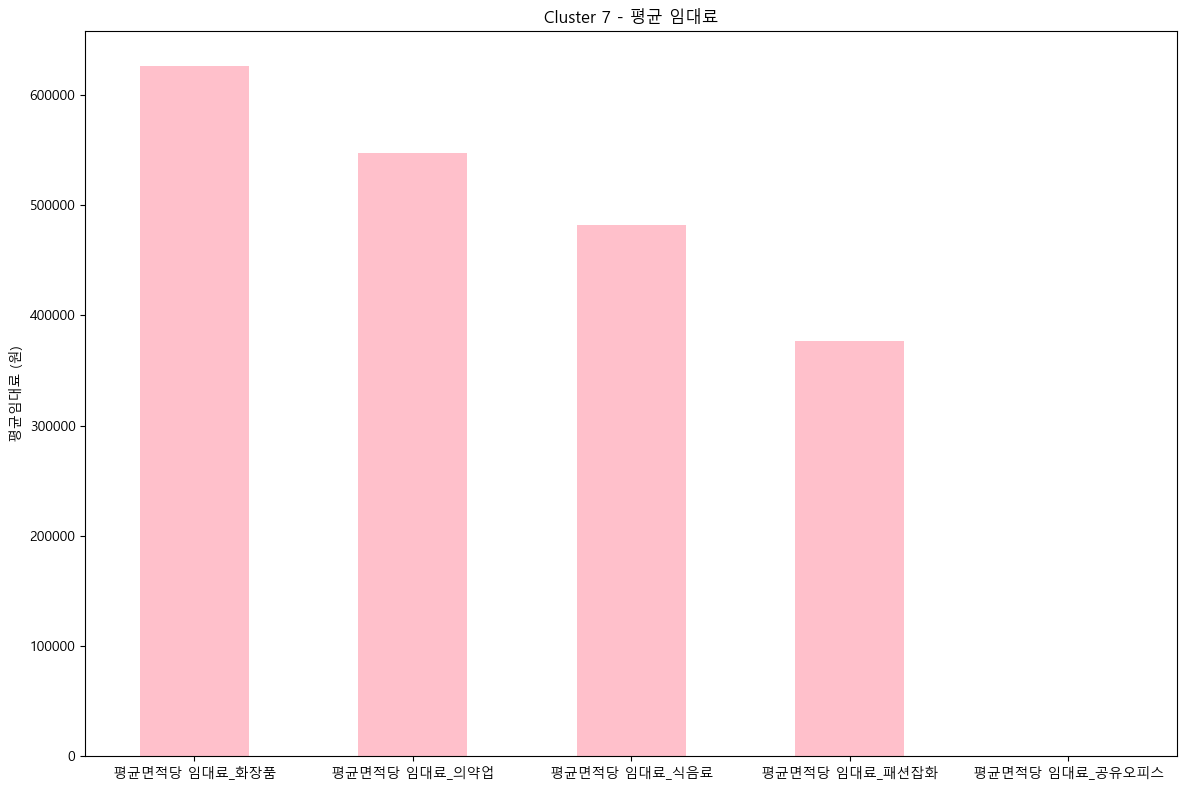

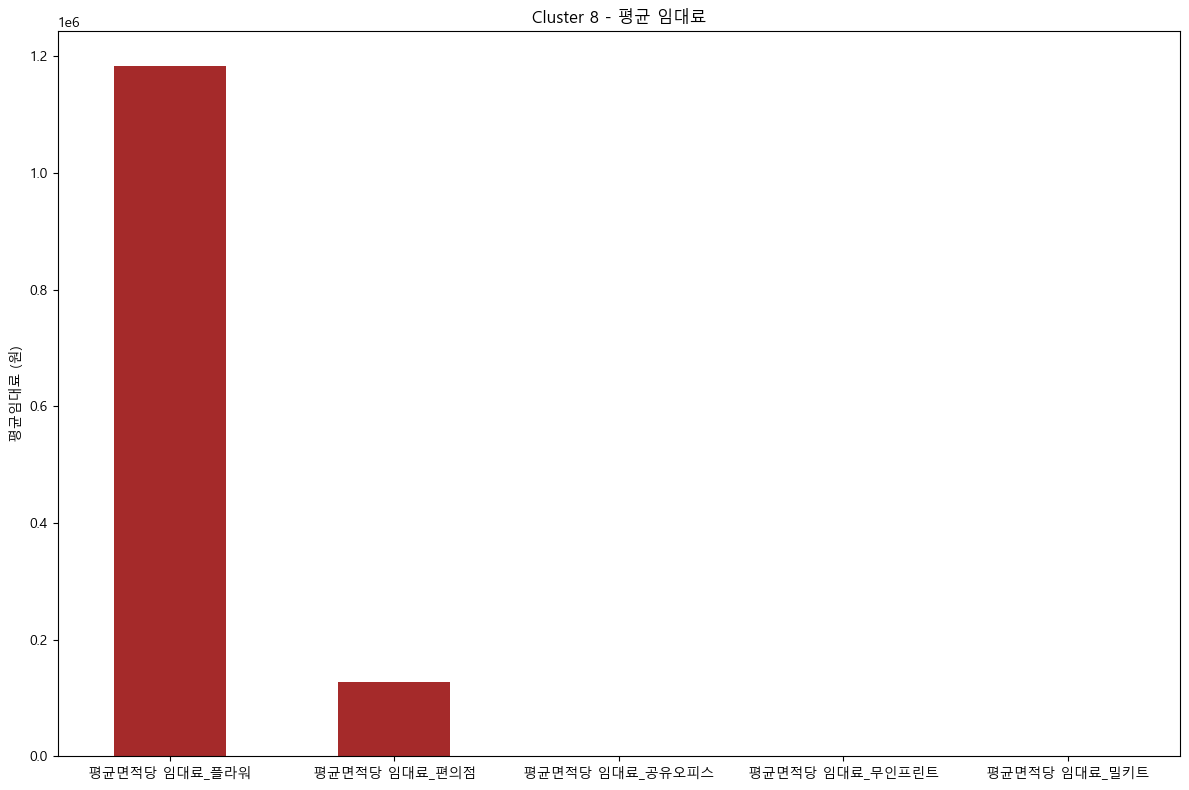

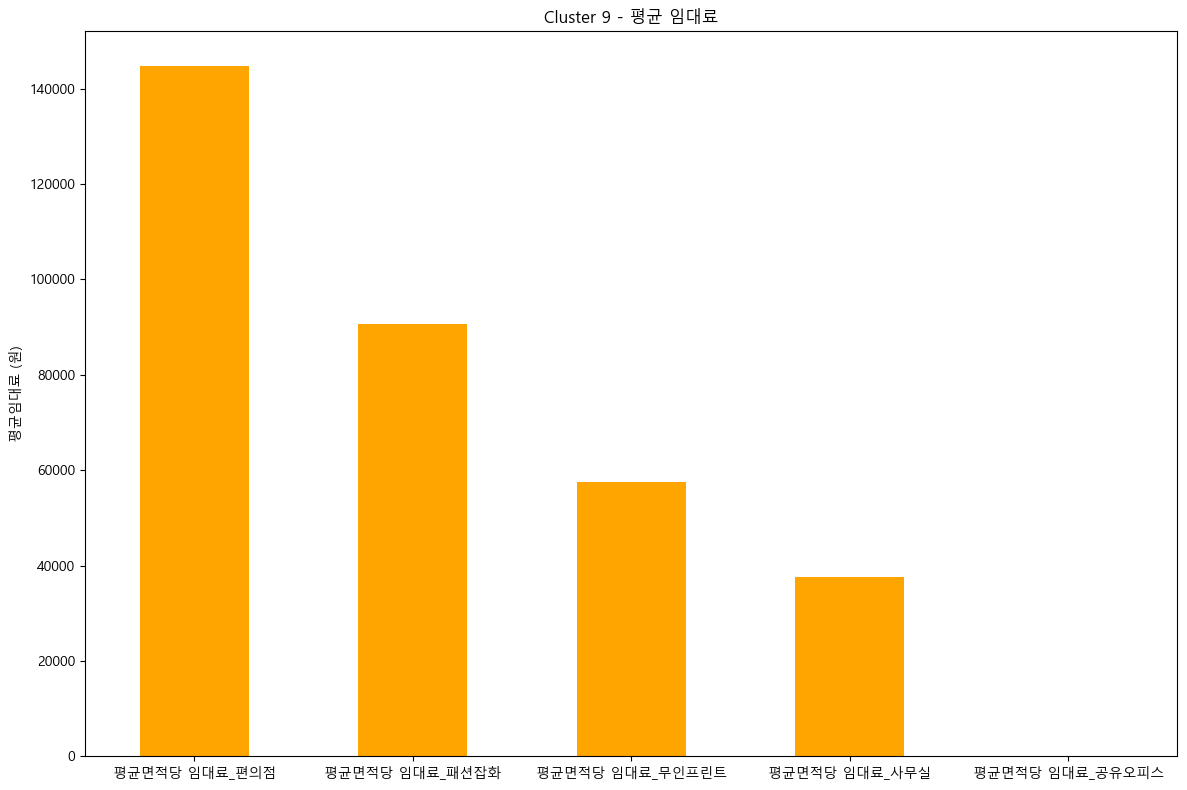

In [ ]:
#한글 읽히게
plt.rcParams['font.family'] = 'Malgun gothic'
plt.rcParams['axes.unicode_minus'] = False

# 색상 목록
colors = ['orange', 'skyblue', 'green', 'purple', 'red', 'gold', 'teal', 'blue', 'pink', 'brown']

# 클러스터별 시각화
for i, (label, row) in enumerate(grouped_pot.iterrows()):
    plt.figure(figsize=(12, 8))
    
      # 상위 5개 업종만 추출
    top5 = row.sort_values(ascending=False).head(5)

    # 막대 그래프 그리기
    top5.plot(kind='bar', color=colors[i % len(colors)])


    plt.title(f"Cluster {label} - 평균 임대료")
    plt.ylabel("평균임대료 (원)")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

#### 클러스터별 최고값 하나씩 뽑아서 클러스터간 평균면적당 월임대료 차이 관측

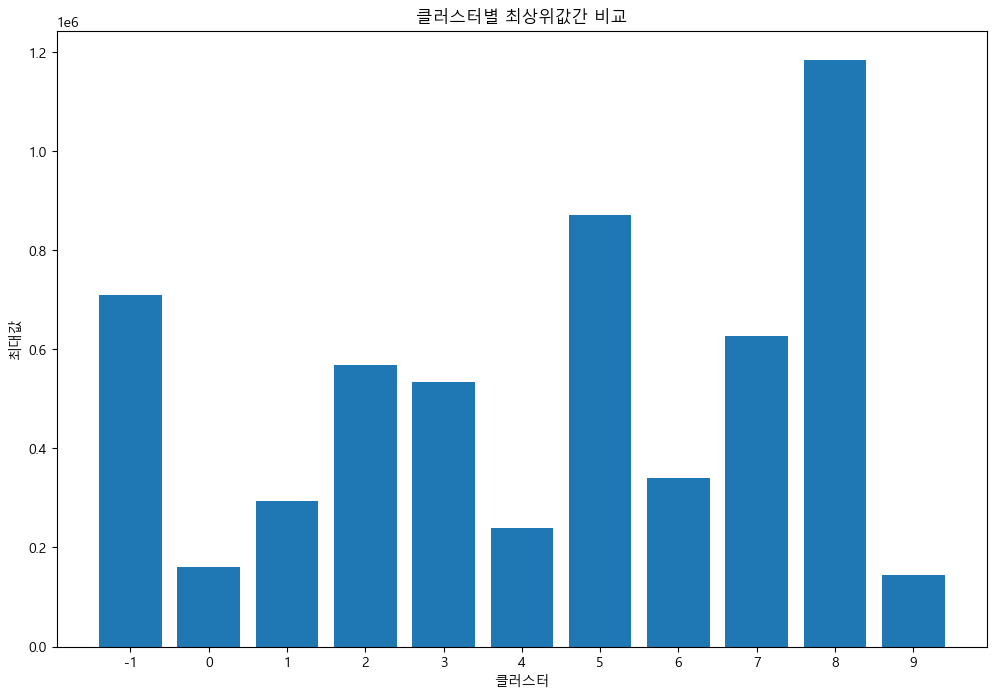

In [35]:
plt.figure(figsize=(12,8))

clusters = ['-1','0','1','2','3','4','5','6','7','8','9']
values = [710000, 160998,292917,568750,534323,238617,871686,339432,626323,1183805,144773]

plt.bar(clusters,values)
plt.title("클러스터별 최상위값간 비교")
plt.xlabel("클러스터")
plt.ylabel("최대값")
plt.show()

1. 특정 업종 임대료가 압도적인 경우 -> 중심 상권
2. 여러 업종이 고르게 높은 경우 -> 유동인구와 상업수요가 전반적으로 높을수도
3. 일부 업종만 존재 & 극단적 편차 -> 특수 목적지, 데이터 편향

- 클러스터명 : 임대료 순위 / 상위 5개 우세한 업종
- -1(노이즈): 3 / 패션잡화(710,000), 플라워(79095)
- 0: 임대료 : 10 / 편의점(160,998), 식음료(98,311), 패션잡화(61,517), 플라워(35,249), 화장품(33,523) | 편의점이나 식음료같은 생활형 업종이 약간 우세하며,  전체적으로 임대료가 낮아보임 > 생활형 소비중심, 주거지 주변이나 대학가 일수도
- 1: 임대료 : 8 / 화장품(292,917), 편의점(229,253), 식음료(122,516), 패션잡화(88,278), 플라워(50,885) |
화장품이나 패션잡화같은 고소비 업종이 상위에 위치함. > 도심 번화가거나 관광지?

- 2: 임대료 : 5 / 플라워(568,750), 식음료(554,226), 패션잡화(365,357) |
특정 업종이 높은임대료로 입점>백화점 주변이나 프리미엄 상업지구일수도

- 3: 임대료 : 6 / 화장품(534,323), 식음료(458,091), 패션잡화(449,735), 편의점(353,961), 의약업(323,014) | 다양한 업종이 평균적으로 높은 평균면적당 임대료. 고소비 업종도 좀 보임. > 강남역같은 상업지구면서 업무지구일 지역일 가능성

- 4: 임대료 : 9 / 패션잡화(238,617), 식음료(160,904), 편의점(72,706), 공유오피스(18,441) |
대체로 임대료가 낮음. 공유오피스가 포함되어있음. 업무지구일수도. 

- 5: 임대료 : 2 / 편의점(871,686), 의약업(349,432), 식음료(258,409), 패션잡화(198,951), 플라워(114,791) | 편의점이 압도적임. 의약업과 식음료도 꽤 고가.  > 유동인구 유입이 많으니 편의점의 수입이 높은 것인가? > 교통 중점일수도 있음.

- 6: 임대료 : 7 / 식음료(339,432), 편의점(296,597), 화장품(223,724), 패션잡화(180,915), 플라워(143,110) | 주소비업종이 평균적으로 높음, 강남역보다 좀 떨어지는 혼합형 상권일수도? 

- 7: 임대료 : 4 / 화장품(626,323), 의약업(547,038), 식음료(481,520), 패션잡화(376,678) | 
고가브랜드가 평균면적당 임대료 높음 > 고부가가치 브랜드 소비 중심> 프리미엄엄 상업지구일수도 있는데 2번보다 전반적으로 높음. 명동같은 핵심소비상권일수도 있음.

- 8: 임대료 : 1 / 플라워(1,183,805), 편의점(128,177) |
플라워가 엄청 높음. 원예단지나 혹은 노이즈일수도

- 9: 임대료 : 11 / 편의점(144,773), 패션잡화(90,584), 무인프린트(57,432), 사무실(37,625) |
편의점 무인프린트 사무실 등 저가 업종 위주 > 개발초기지역이나 저비용 창업 가능 지역이 아닐까


####  업종별 밀집도 특성
- 클러스터/ 우세업종
- 0 / 패션잡화(2.5), 식음료(1.9), 편의점(0.9) 종합생활상권이고 대중적 업종이 적절히 분포함.
- 1 / 패션잡화(2.7) , 밀키트 (1.0), 편의점(0.9) 밀키트 밀집은 특정 트랜드에 반영하는 지역이거나 1인 가구가 많은 지역일수도 있음

- 대체적으로 패션잡화는 밀집도가 높다. 수요가 높다는 의미이기도 하지만 동시에 입점하긴 불리한 지역이라고 할 수 있다.

### **4.최적 입지 추천**

#### 클러스터별 특성 column으로 만들어서 붙이기.

In [36]:
#클러스터 이름 변경
total_pop_df = total_pop_df.rename(columns ={'kmeans_label' : '총인구클러스터'})
minor_pop_df = minor_pop_df.rename( columns = {'kmeans_label' : '미성년인구클러스터'})
adult_pop_df = adult_pop_df.rename( columns ={'dbscan_label' : '성인인구클러스터'})
old_pop_df = old_pop_df.rename(columns = {'dbscan_label' : '노인인구클러스터'})
for_pop_df = for_pop_df.rename(columns = {'dbscan_label' : '외국인인구클러스터'})

potential_df = potential_df.rename(columns = {'dbscan_label' : '잠재수요클러스터'})

density_df = density_df.rename(columns ={'kmeans_label' : '업종밀도클러스터'})

In [ ]:
# 총인구 클러스터
total_explanation = {
    0 : "유동인구 적음",
    1 : "유동인구 많음"
}
total_pop_df["총유동인구해석"] = total_pop_df["총인구클러스터"].map(total_explanation)

#미성년클러스터
minor_explanation = {
    0 : "미성년 유동인구 적음",
    1 : "미성년 유동인구 많음"
}
minor_pop_df["미성년유동인구해석"] = minor_pop_df["미성년인구클러스터"].map(minor_explanation)

#성인인구클러스터
adult_explanation = {
    0 : " 성인 유동인구 많음",
    1 : "성인 유동인구 적음"
}
adult_pop_df["성인유동인구해석"] = adult_pop_df["성인인구클러스터"].map(adult_explanation)

#노인인궄클러스터
old_explanation = {
    0 : " 노인 유동인구 적음",
    1 : "노인 유동인구 많음"
}
old_pop_df["노인유동인구해석"] = old_pop_df["노인인구클러스터"].map(old_explanation)

#외국인인구클러스터
for_explanation = {
    -1 : "외국인 유동인구 중간, 밀도 낮아 군집화 실패",
    0 : " 외국인 유동인구 적음",
    1 : "외국인 유동인구 많음"
}
for_pop_df["외국인유동인구해석"] = for_pop_df["외국인인구클러스터"].map(for_explanation)


# 잠재수익
potential_explanation = {
    -1: "노이즈 클러스터 - 패션잡화 강세, 유효하지 않거나 기준부족",
     0: "생활형 상권 - 편의점, 식음료 중심",
     1: "도심유동 상권 - 화장품, 젊은층 타겟",
     2: "고급소비 상권 - 플라워, 고임대",
     3: "복합중심 상업지구 - 다양한 고가 업종",
     4: "중규모 업무상권 - 패션잡화, 식음료",
     5: "교통유입 중심 - 편의점 강세",
     6: "균형 상권 - 여러 업종 평균 분포",
     7: "핵심 소비 상권 - 화장품, 의약업 고임대",
     8: "플라워 특화 상권 - 일부 업종 특화",
     9: "저비용입지 - 무인 업종 중심"
}

potential_df["잠재수요해석"] = potential_df["잠재수요클러스터"].map(potential_explanation)

profit_level = {
    -1: '수익 낮음',
     0: '수익 낮음',
     1: '수익 중간',
     2: '수익 높음',
     3: '수익 높음',
     4: '수익 낮음',
     5: '수익 높음',
     6: '수익 중간',
     7: '수익 높음',
     8: '수익 중간',
     9: '수익 낮음'
}

potential_df["잠재수요등급"] = potential_df["잠재수요클러스터"].map(profit_level)

# 업종밀도클러스터
density_explanation = {
    0 : "패션잡화(2.5), 식음료(1.9), 편의점(0.9) 종합생활상권이고 대중적 업종이 적절히 분포함.",
    1 : "패션잡화(2.7) , 밀키트 (1.0), 편의점(0.9) 밀키트 밀집은 특정 트랜드에 반영하는 지역이거나 1인 가구가 많은 지역일수도 있음"
}
density_df["업종밀도해석"] = density_df["업종밀도클러스터"].map(density_explanation)

In [39]:
density_df.head()

,역명,month,점포수_공유오피스,점포수_무인프린트,점포수_밀키트,점포수_사무실,점포수_식음료,점포수_의약업,점포수_패션잡화,점포수_편의점,점포수_플라워,점포수_화상면접,점포수_화장품,업종밀도클러스터,업종밀도해석
0,가락시장역,1,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0,"패션잡화(2.5), 식음료(1.9), 편의점(0.9) 종합생활상권이고 대중적 업종이..."
1,가락시장역,1,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0,"패션잡화(2.5), 식음료(1.9), 편의점(0.9) 종합생활상권이고 대중적 업종이..."
2,강남구청역,1,0.0,0.0,0.0,0.0,0.0,2.0,5.0,1.0,1.0,0.0,0.0,0,"패션잡화(2.5), 식음료(1.9), 편의점(0.9) 종합생활상권이고 대중적 업종이..."
3,강남구청역,1,0.0,0.0,0.0,0.0,0.0,2.0,5.0,1.0,1.0,0.0,0.0,0,"패션잡화(2.5), 식음료(1.9), 편의점(0.9) 종합생활상권이고 대중적 업종이..."
4,강동구청역,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,"패션잡화(2.5), 식음료(1.9), 편의점(0.9) 종합생활상권이고 대중적 업종이..."


#### 클러스터 라벨과 테이블 결합.

In [ ]:
keys = ["month","역명"]

result_df = pd. merge(merged_df, total_pop_df, on=keys+total_pop, how = "inner" )
result_df = pd.merge(result_df,minor_pop_df , on=keys+minor_pop,how="inner")
result_df = pd.merge(result_df,adult_pop_df , on=keys+adult_pop,how="inner")
result_df = pd.merge(result_df,old_pop_df, on=keys+old_pop,how="inner")
result_df = pd.merge(result_df,for_pop_df, on=keys+for_pop,how="inner")
result_df = pd.merge(result_df,potential_df, on=keys+potential,how="inner")
result_df = pd.merge(result_df,density_df, on=keys+density,how="inner")

- 이거 하다가 잘못해서 중복된 행이 4개씩 생겼습니다. 아마 승차 하차 이걸 초반에 드랍 안 해서 그런 것 같아요.
- 초반에 승차 하차를 구분하는게 의미가 있다고 생각했고, 지금도 그렇게 생각합니다. 그래서 이건 남겨놓을까 해요.
- 앞부분 전처리를 다시 하는 방법도 있겠다만, 그건 수정해야 할 게 너무 많아집니다. 그래서 단순히 중복된 행만 여기서 처리하도록 하겠습니다

In [41]:
result_df = result_df.drop_duplicates(subset=['month','역명','승하차구분'])

In [42]:
result_df.to_csv("result_df.csv",encoding="utf-8-sig")

#### 역명 검색시 상권 특성 도출 가능

In [43]:
# Boolean 조건을 먼저 정의
condition = (result_df['역명'] == '가락시장역') & (result_df['month'] == 1)

# 조건을 이용해 원하는 열만 출력
print(result_df.loc[condition, ['역명','총유동인구해석', '미성년유동인구해석', '성인유동인구해석',
                                '노인유동인구해석', '외국인유동인구해석', '잠재수요해석', '업종밀도해석']])

      역명  총유동인구해석    미성년유동인구해석     성인유동인구해석     노인유동인구해석     외국인유동인구해석  \
0  가락시장역  유동인구 적음  미성년 유동인구 적음   성인 유동인구 많음   노인 유동인구 적음   외국인 유동인구 적음   
4  가락시장역  유동인구 적음  미성년 유동인구 적음   성인 유동인구 많음   노인 유동인구 적음   외국인 유동인구 적음   

                 잠재수요해석                                             업종밀도해석  
0  생활형 상권 - 편의점, 식음료 중심  패션잡화(2.5), 식음료(1.9), 편의점(0.9) 종합생활상권이고 대중적 업종이...  
4  생활형 상권 - 편의점, 식음료 중심  패션잡화(2.5), 식음료(1.9), 편의점(0.9) 종합생활상권이고 대중적 업종이...  


#### 입지 유형

In [46]:
def classify(row):
    adult = str(row.get('성인유동인구해석', '')).strip()
    foreign = str(row.get('외국인유동인구해석', '')).strip()
    minor = str(row.get('미성년유동인구해석', '')).strip()
    old = str(row.get('노인유동인구해석', '')).strip()
    total = str(row.get('총유동인구해석', '')).strip()
    density = str(row.get('업종밀도해석', '')).strip()
    empty = row.get('공실수', 0)
    profit = str(row.get('잠재수요등급', '')).strip() 

   
    # 유동인구 적음 + 수익 낮음
    if total == '유동인구 적음' and profit == '수익 낮음':
        return '비추천'

    # 유동인구 적음
    if total == '유동인구 적음':
        return '일반'

    # 프리미엄 추천
    if profit == '수익 높음' and adult == '성인 유동인구 많음' and empty > 0:
        return '프리미엄 추천'

    # 추천
    if adult == '성인 유동인구 많음' and empty > 0 and \
       (minor == '미성년 유동인구 많음' or foreign == '외국인 유동인구 많음'):
        return '추천'

    # 안정형
    if old == '노인 유동인구 많음' and empty <= 1:
        return '안정형'

    # 미성년 특화형
    if minor == '미성년 유동인구 많음' and old != '노인 유동인구 많음' and \
       empty > 1 and '밀집' not in density and '강세' not in density:
        return '미성년 특화형'

    # 노인 특화형
    if old == '노인 유동인구 많음' and minor != '미성년 유동인구 많음' and \
       empty > 1 and '밀집' not in density and '강세' not in density:
        return '노인 특화형'

    # 비추천 (경쟁 치열 + 공실 없음)
    if ('밀집' in density or '강세' in density) and empty <= 1:
        return '비추천'

    # 수익 낮음이면 일반
    if profit == '수익 낮음':
        return '일반'

    # 기본값
    return '일반'

In [47]:
result_df['입지유형'] = result_df.apply(classify, axis =1)

result_df.to_csv('result_df.csv',encoding='utf-8-sig')

#### 업종별 스코어 추가

- 스코어는 해당 역의 업종당 평균면적당 임대료와 업종별 점포수로 평가하겠습니다


In [ ]:
#features = ['month', '역명', '승하차구분', '미성년_아침_유동인구', '미성년_점심_유동인구', '미성년_저녁_유동인구',
# '성인_아침_유동인구', '성인_점심_유동인구', '성인_저녁_유동인구',
# '노인_아침_유동인구', '노인_점심_유동인구', '노인_저녁_유동인구',
# '외국인_아침_유동인구', '외국인_점심_유동인구', '외국인_저녁_유동인구', '총유동인구',
# '평균면적당 임대료_공유오피스', '평균면적당 임대료_기타', '평균면적당 임대료_무인프린트', '평균면적당 임대료_밀키트',
# '평균면적당 임대료_사무실', '평균면적당 임대료_식음료', '평균면적당 임대료_의약업', '평균면적당 임대료_패션잡화',
# '평균면적당 임대료_편의점', '평균면적당 임대료_플라워', '평균면적당 임대료_화상면접', '평균면적당 임대료_화장품',
# '공실수', '점포수_공유오피스', '점포수_기타', '점포수_무인프린트', '점포수_밀키트',
# '점포수_사무실', '점포수_식음료', '점포수_의약업', '점포수_패션잡화',
# '점포수_편의점', '점포수_플라워', '점포수_화상면접', '점포수_화장품']

In [ ]:
location_recommand = result_df[['month','역명','승하차구분','입지유형']]

categories = ['식음료','패션잡화','편의점','화장품','플라워','의약업','무인프린트','밀키트','사무실','공유오피스','화상면접']


for category in categories:
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = result_df[f'평균면적당 임대료_{category}'] / result_df[f'점포수_{category}']
        ratio = (ratio.replace([np.inf, -np.inf], np.nan).fillna(0) / 1000).round().astype(int)
        location_recommand.loc[:, category] = ratio 
#입지특성도 볼수있게 붙였습니다.
location_recommand['입지특성'] = result_df['총유동인구해석'] + '/' + result_df['미성년유동인구해석'] + '/' + result_df['성인유동인구해석'] + '/' + result_df['노인유동인구해석'] + '/' + result_df['외국인유동인구해석'] + '/' + result_df['잠재수요해석'] + '/' + result_df['잠재수요등급'] + '/' + result_df['업종밀도해석']



# CSV 저장
location_recommand.to_csv('location_suggestion.csv', encoding='utf-8-sig', index=False)

C:\Users\준영\AppData\Local\Temp\ipykernel_33236\1151698154.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_recommand.loc[:, category] = ratio
C:\Users\준영\AppData\Local\Temp\ipykernel_33236\1151698154.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_recommand.loc[:, category] = ratio
C:\Users\준영\AppData\Local\Temp\ipykernel_33236\1151698154.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val